<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1TRNaCfYstvcIQqoUSdukYQGF6LuyL7Tv" width=600 height=320/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

# Домашнее задание. Автоэнкодеры


# Часть 1. Vanilla Autoencoder (10 баллов)

In [1]:
!pip install -q py-cpuinfo

## 1.1. Подготовка данных (1 балл)


In [2]:
import numpy as np
from torch.autograd import Variable
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt

import os
import pandas as pd
import skimage.io
from skimage.transform import resize

import cpuinfo
import platform
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm, trange
from torch.utils.data import DataLoader, TensorDataset
from IPython.display import clear_output
from typing import Union

%matplotlib inline

In [3]:
def tprint(message,verb=True):   
    import requests    # подробнее об этом: https://pythonist.ru/otpravka-soobshhenij-v-telegram-pri-pomoshhi-python/
    TOKEN = "5979454825:AAH8n7awvogIwLyHMk_zeqfVq92n_54e4Bs" # Мой токен бота для уведомлений
    chat_id = "232987571"                                    # Мой ID 
    url = f"https://api.telegram.org/bot{TOKEN}/sendMessage?chat_id={chat_id}&text={message}"
    requests.get(url).json() # отправка сообщения
    if verb:
        print(message)

In [4]:
# ДОБАВИМ БЛОК ДЛЯ ФИКСАЦИИ ГЕНЕРАТОРОВ СЛУЧАЙНЫХ ЧИСЕЛ
import random

def seed_everything(seed):
    
    random.seed(seed)  # Зафиксировать генератор случайных чисел в Python
    np.random.seed(seed) # Зафиксировать генератор случайных чисел NumPy
    torch.manual_seed(seed) # Зафиксировать генератор случайных чисел PyTorch для CPU
    if torch.cuda.is_available(): # Если CUDA генерирует случайные числа, то нужно зафиксировать и его        
        torch.cuda.manual_seed(seed) # Зафиксировать генератор случайных чисел PyTorch для всех GPU
        torch.cuda.manual_seed_all(seed) # Зафиксировать генератор случайных чисел PyTorch для всех GPU
        torch.backends.cudnn.deterministic = True   # Использование детерминированных алгоритмов        
        torch.backends.cudnn.benchmark = False # Отключение оптимизации, для воспроизводимости результатов

# пример использования
SEED = 42
seed_everything(SEED)

In [5]:
def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,  dy=80,
                      dimx=64,dimy=64
    ):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        if platform.system().lower().startswith('win'):
            os.system("wsl wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
            print("extracting...")
            os.system("wsl tar xvzf tmp.tgz && rm tmp.tgz")
        else:
            os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
            print("extracting...")        
            os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        if platform.system().lower().startswith('win'):
            os.system("wsl wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        else:
            os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,)
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    # print(photo_ids)
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    # print(df.shape)
    #image preprocessing
    all_photos =df['photo_path'].apply(skimage.io.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: resize(img,[dimx,dimy]))

    all_photos = np.stack(all_photos.values)#.astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)

    return all_photos, all_attrs

In [6]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind

data, attrs = fetch_dataset()


Разбейте выборку картинок на train и val, выведите несколько картинок в output, чтобы посмотреть, как они выглядят, и приведите картинки к тензорам pytorch, чтобы можно было скормить их сети:

In [7]:
#<тут Ваш код>

n_objs = len(data) 

imgs_train, imgs_val, attr_train, attr_val = train_test_split(data,attrs, test_size=0.2, shuffle=False) 


imgs_train = torch.FloatTensor(np.rollaxis(imgs_train, 3, 1))
imgs_val   = torch.FloatTensor(np.rollaxis(imgs_val,   3, 1))

dataset_train = TensorDataset(imgs_train)
dataset_val   = TensorDataset(imgs_val  )

train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=32,shuffle=False)
val_loader   = torch.utils.data.DataLoader(dataset_val,   batch_size=32,shuffle=False)
vis_loader   = torch.utils.data.DataLoader(dataset_val,   batch_size=32,shuffle=True)

Вывод картинок

In [8]:
n_images = 12
rnd_images = np.random.choice(len(data), size = n_images, replace = False)

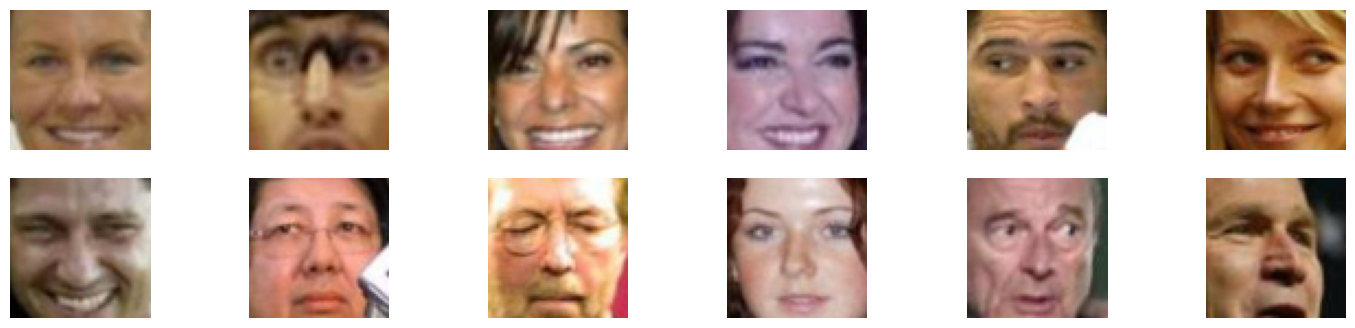

In [9]:
x_tiles = 6
y_tiles = 2

plt.figure(figsize=(18,y_tiles*2))

for i in range(n_images):
    im_index = rnd_images[i]
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(data[im_index])

plt.show()

Дополнительно. Выведем информацию об устройстве, которое будет использоваться для расчетов (более детальную чем просто cuda/cpu информацию о процессоре или видеокарте)

In [10]:
# получаем название процессора и число потоков для использования в протоколах работы 
CPU_INFO = f"{cpuinfo.get_cpu_info()['brand_raw']} ({cpuinfo.get_cpu_info()['count']} threads)"

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if str(DEVICE).lower().startswith('cuda'):
    dev_list = []
    device_count = torch.cuda.device_count()
    for i in range(device_count):
        device_name = torch.cuda.get_device_name(i)
        dev_list.append(device_name)
    DEVICENAME = ', '.join(dev_list)
else:
    DEVICENAME = CPU_INFO

print(f"Устройство, используемое для расчетов: { DEVICENAME } ({DEVICE})")


Устройство, используемое для расчетов: NVIDIA GeForce RTX 4090 (cuda)


In [11]:
# функция подсчета числа гиперпараметров модели
def count_parameters(model):
    """
    Returns the number of trainable parameters
    
    Parameters:
        model - pytorch model object
        
    Returns:
        (int) - number of trainable parameters
    """
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [12]:
# функция которая возвращает устройство, в памяти которого находится модель
def get_model_device(model):    
    """
    Returns a device name for the given model
    
    Parameters:
        model - pytorch model object
        
    Returns:
        device name (string). 'cpu', 'cuda' or like that
    """
    curr_device = str([param for name, param in model.named_parameters()][0].device)    
    return curr_device

## 1.2. Архитектура модели (2 балла)
В этом разделе мы напишем и обучем обычный автоэнкодер.



<img src="https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2F4b8adf79-8e6a-4b7d-9061-8617a00edbb1%2F__2021-04-30__14.53.33.png?table=block&id=56f187b4-279f-4208-b1ed-4bda5f91bfc0&width=2880&userId=3b1b5e32-1cfb-4b0f-8705-5a524a8f56e3&cache=v2" alt="Autoencoder">


^ напомню, что автоэнкодер выглядит вот так

In [13]:
# выберите размер латентного вектора
DIM_CODE = 64 # будем делать сверточный кодировщик-декодировщик с 64 каналами

Реализуем autoencoder. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Экспериментируйте!

In [14]:
from copy import deepcopy

class Autoencoder(nn.Module):
    def __init__(self):
        # <определите архитектуры encoder и decoder>
        # Обратите внимание на формат, в котором функция fetch() возвращает data
        super(Autoencoder,self).__init__()
        
        # self.mean       = 0 # среднее
        # self.std        = 0 # отклонение
        # self.n_objects  = 0 # число объектов, на которых обучена сеть
        
        self.encoder = nn.Sequential(
            nn.Conv2d(3,  16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, DIM_CODE, 3, stride=2, padding=1),
            nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(DIM_CODE, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def get_latent_vector(self, x):
        latent_vector = self.encoder(x)
        return latent_vector
    
    def get_latent_distribution_from_dataset(self,dataset):
        latent_vectors = []
        with torch.no_grad():
            for object in dataset:
                temp_vector = autoencoder.get_latent_vector(object[0].reshape(-1,3,64,64))
                latent_vectors.append(temp_vector)
        latent_tensor = torch.cat(latent_vectors,dim=0)
        mean = torch.mean(latent_tensor,dim=0)
        std  = torch.std(latent_tensor,dim=0)
        return mean, std

    def forward(self, x):
        # <реализуйте forward проход автоэнкодера
        # в качестве возвращаемых переменных -- латентное представление картинки (latent_code)
        # и полученная реконструкция изображения (reconstruction)>
        
        latent_vector  = self.encoder(x)
        reconstruction = self.decoder(latent_vector)

        return reconstruction, latent_vector

## 1.3 Обучение (2 балла)

Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэекодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

In [15]:
n_epochs     = 80
train_losses = []
val_losses   = []

In [16]:
criterion = F.mse_loss # выбор функции ошибки
autoencoder = Autoencoder()
optimizer = torch.optim.Adam(autoencoder.parameters()) # выбор оптимизатора

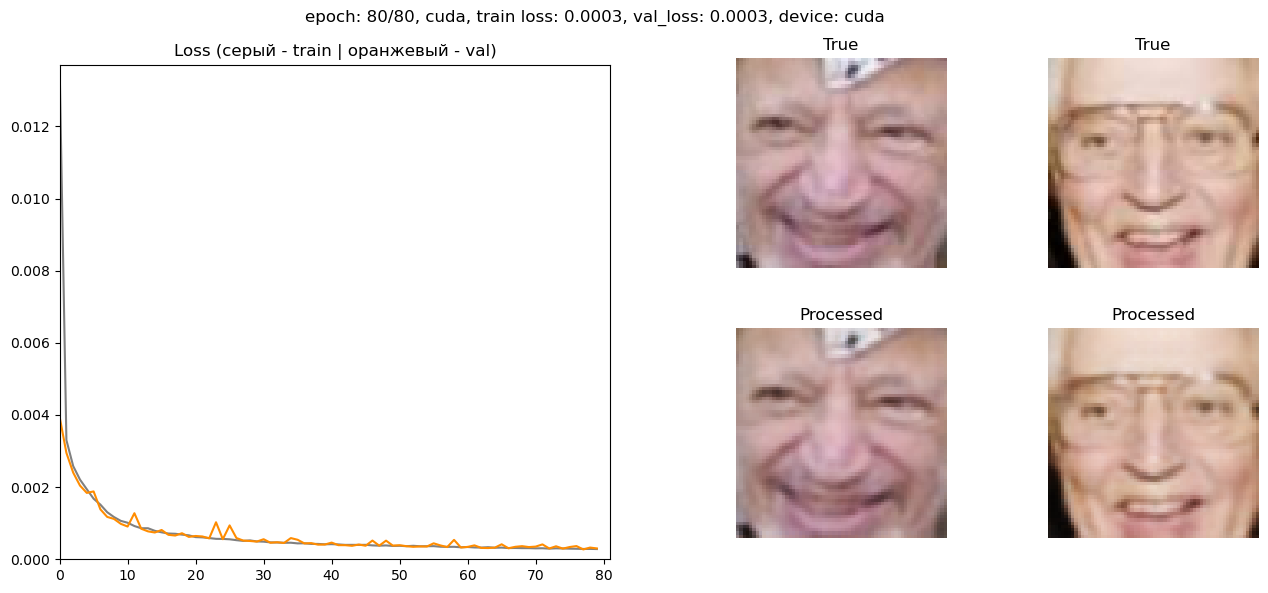

In [17]:
max_error = 0

# <тут Ваш код тренировки автоэнкодера>
device = DEVICE

autoencoder = autoencoder.to(device)
visloader_enumerator = iter(vis_loader)

with trange(1, n_epochs + 1, desc="epochs") as pbar:
    for e in pbar:
        autoencoder.train()
        train_losses_per_epoch = []
        for batch_data in train_loader:
            batch = batch_data[0]
            optimizer.zero_grad()
            reconstruction_train, latent_code_train = autoencoder(batch.to(device))
            loss = criterion(batch.to(device), reconstruction_train)
            loss.backward()
            optimizer.step()
            train_losses_per_epoch.append(loss.item())

        mean_train_loss = np.mean(train_losses_per_epoch)
        train_losses.append(mean_train_loss)
        if mean_train_loss > max_error:
            max_error = mean_train_loss

        autoencoder.eval()
        val_losses_per_epoch = []
        with torch.no_grad():
            for batch_data_val in val_loader:
                batch_val = batch_data_val[0].to(device)
                reconstruction_val, latent_code_val = autoencoder(batch_val)
                loss = criterion(batch_val, reconstruction_val)
                val_losses_per_epoch.append(loss.item())

        mean_val_loss = np.mean(val_losses_per_epoch)
        val_losses.append(mean_val_loss)
        if mean_val_loss > max_error:
            max_error = mean_val_loss

        # Визуализация
        autoencoder.eval()  # testing mode
        images_vis = next(visloader_enumerator)
        x_images_vis = images_vis[0].to(DEVICE)
        y_images_vis, latent_code_vis = autoencoder.forward(x_images_vis) # Перенос из памяти GPU в CPU
        y_images_vis = y_images_vis.detach().cpu()
        x_images_vis = x_images_vis.cpu()
        clear_output(wait=True)
        
        ##################################################################
        # Отприсовка графиков ошибок и примеров обработанных изображений #
        ##################################################################

        # Определение размера фигуры
        fig = plt.figure(figsize=(12, 6))

        # Создание графика функции с заданным соотношением размеров
        ax1 = fig.add_subplot(121)
        ax1.plot(train_losses, label="Train loss"     ,color='gray')
        ax1.plot(val_losses,   label="Validation loss",color='darkorange')
        ax1.set_xlim(0,n_epochs+1)
        ax1.set_ylim(0,max_error)
        ax1.set_title("Loss (серый - train | оранжевый - val)")

        # Определение позиций для изображений
        # Прямоугольник: [x, y, width, height]
        base_width, base_height = 0.35, 0.35  # Увеличены на 25%
        
        image_positions = [(0.53, 0.55, base_width, base_height),  # Вычитаем (0.25 * height)/2 из y для компенсации
                           (0.79, 0.55, base_width, base_height),  # Высота изображений корректирована также
                           (0.53, 0.1, base_width, base_height),
                           (0.79, 0.1, base_width, base_height)]

        # Итерация для создания изображений
        for idx, pos in enumerate(image_positions):
            ax = fig.add_axes(pos)

            if idx == 0:
                ax.imshow(np.rollaxis(x_images_vis[0].numpy(), 0, 3))  
                ax.set_title(f"True")
            if idx == 1:
                ax.imshow(np.rollaxis(x_images_vis[1].numpy(), 0, 3))  
                ax.set_title(f"True")
            if idx == 2:
                ax.imshow(np.rollaxis(y_images_vis[0].numpy(), 0, 3))  
                ax.set_title(f"Processed")
            if idx == 3:
                ax.imshow(np.rollaxis(y_images_vis[1].numpy(), 0, 3))  
                ax.set_title(f"Processed")
            
            # Удаление осей для изображения
            ax.axis('off')

        plt.suptitle(f"epoch: {e}/{n_epochs}, {device}, train loss: {mean_train_loss:.4f}, val_loss: {mean_val_loss:.4f}, device: {DEVICE}")
        
        plt.tight_layout()
        plt.show()
        
autoencoder = autoencoder.cpu()
torch.cuda.empty_cache()
        

Давайте посмотрим, как наш тренированный автоэекодер кодирует и восстанавливает картинки:

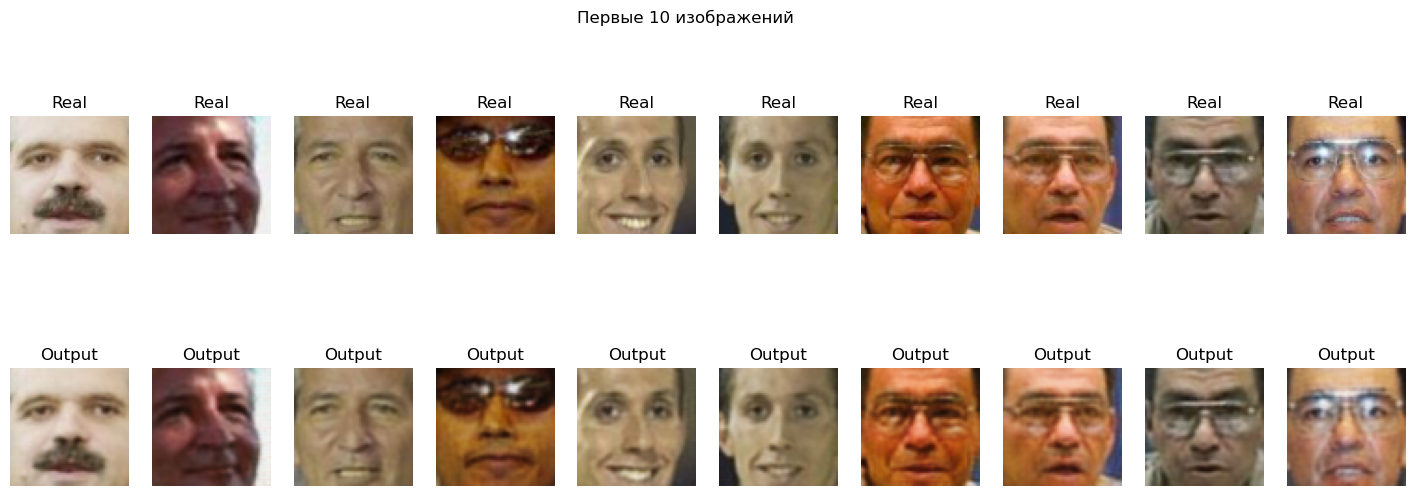

In [18]:
# <тут Ваш код: выведите первые Х картинок и их реконструкций из val выборки на экран>
autoencoder = autoencoder.to(DEVICE)

n_pics = 10

# Визуализация
autoencoder.eval()  # testing mode
images_vis = val_loader.dataset.tensors[0][:n_pics,:,:,:]

x_images_vis = images_vis.to(DEVICE)
y_images_vis, latent_code_vis = autoencoder.forward(x_images_vis) # Перенос из памяти GPU в CPU
y_images_vis = y_images_vis.detach().cpu()
x_images_vis = x_images_vis.cpu()
#print(f"x_images_vis.shape: {x_images_vis.shape}")
clear_output(wait=True)

plt.figure(figsize=(18,6))
for k in range(n_pics):
    plt.subplot(2, n_pics, k+1)#k+1)
    plt.imshow(np.rollaxis(x_images_vis[k].numpy(), 0, 3) )#, cmap='gray')
    plt.title('Real')
    plt.axis('off')

    plt.subplot(2, n_pics, k+11)#k+7)
    plt.imshow( np.rollaxis(y_images_vis[k].numpy(),0,3))
    plt.title('Output')
    plt.axis('off')
plt.suptitle(f"Первые {n_pics} изображений")
plt.show()

autoencoder = autoencoder.cpu()
torch.cuda.empty_cache()

Not bad, right?

## 1.4. Sampling (2 балла)

Давайте теперь будем не просто брать картинку, прогонять ее через автоэекодер и получать реконструкцию, а попробуем создать что-то НОВОЕ

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

__Подсказка:__Е сли вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как `np.random.randn(25, <latent_space_dim>)`. А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как латентные векторы реальных фоток. Так что в таком случае придется рандом немного подогнать.

In [19]:
def get_random_object(batch_size, ae,dataset):
    raw_obj = np.random.randn(batch_size,DIM_CODE,8,8)
    torch_obj = torch.FloatTensor(raw_obj)
    mean, std = ae.get_latent_distribution_from_dataset(dataset)
    torch_obj = torch_obj*std + mean
    return torch_obj

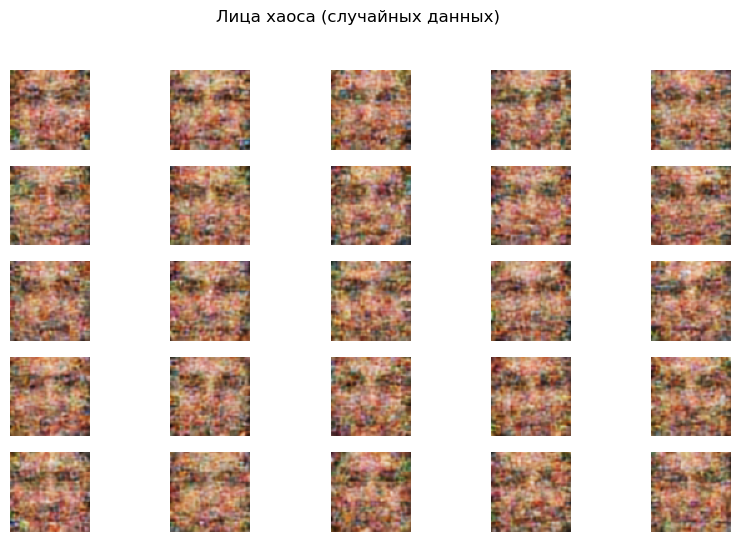

In [20]:
# сгенерируем 25 рандомных векторов размера latent_space
n_pics = 25

z = get_random_object(n_pics, autoencoder, dataset_train)

# <скормите z декодеру>
autoencoder.eval()
with torch.no_grad():
    output = autoencoder.decoder(z).detach().cpu()
    
# <выведите тут полученные картинки>
clear_output(wait=True)

plt.figure(figsize=(10,6))

for k in range(5):
    for l in range(5):
        plt.subplot(5,5,k*5+l+1,frameon=False)
        plt.imshow( np.rollaxis(output[k*5+l].numpy(),0,3))
        plt.axis('off')        

plt.suptitle(f"Лица хаоса (случайных данных)")
plt.show()

autoencoder = autoencoder.cpu()
torch.cuda.empty_cache();

## 1.5 Time to make fun! (3 балла)

Давайте научимся пририсовывать людям улыбки =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

План такой:

1. Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с описанием датасета, скачанный вместе с датасетом. В нем указаны имена картинок и присутствубщие атрибуты (улыбки, очки...)

2. Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3. Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

4. А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного человека и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

#### 1. Выбор изображений

In [21]:
# <ваш код здесь>
# Найдем столбец, отвечающий за улыбку
n_samples = 15 
[a for a in attr_train.columns if a.lower().startswith('smi')]

['Smiling']

In [22]:
type(dataset_val)

torch.utils.data.dataset.TensorDataset

In [23]:
# Добавим метод отображения картинок по индексам
def show_image_by_index(img_index = 0,dataset=dataset_train,plotgrid=(6,5),scale=2,prefix="index: ",postfix=""):
    
    if type(dataset)== torch.utils.data.dataset.TensorDataset:
        dataset = dataset.tensors[0].numpy()
    
    # если получен список индексов, рисуем табличку
    if type(img_index) != int: 
        n_x = plotgrid[1]
        n_y = plotgrid[0]
        plt.figure(figsize=(plotgrid[1]*scale, plotgrid[0]*scale) )
        if n_x*n_y < len(img_index):
            n_y = int(np.ceil(len(img_index)/plotgrid[1]))
        for i in range(len(img_index)):
            plt.subplot(n_y, n_x, i+1)
            img = dataset[i]
            plt.imshow( np.rollaxis(img,0,3))
            plt.axis('off');
            plt.title(f"{prefix}{img_index[i]}{postfix}")
    # если получен один индекс, рисуем одну картинку
    else:
        plt.figure(figsize=(scale*1,scale*1))        
        img = dataset[i]
        plt.imshow( np.rollaxis(img,0,3))
        plt.axis('off');
        plt.title(f"{prefix}{img_index}{postfix}")
    plt.show();

In [24]:
attr_df = pd.DataFrame(attr_train)

In [25]:
smiling_sample_indexes = attr_df.sort_values(by=['Smiling'],ascending=False)['Smiling'].head(n_samples).index
nosmile_sample_indexes = attr_df.sort_values(by=['Smiling'],ascending=True)['Smiling'].head(n_samples).index

In [26]:
smiling_sample_indexes

Int64Index([8643, 1816, 5624, 1045, 4681, 6139, 1359, 2031, 1955, 9004,  459,
            6166,  682,  983, 9165],
           dtype='int64')

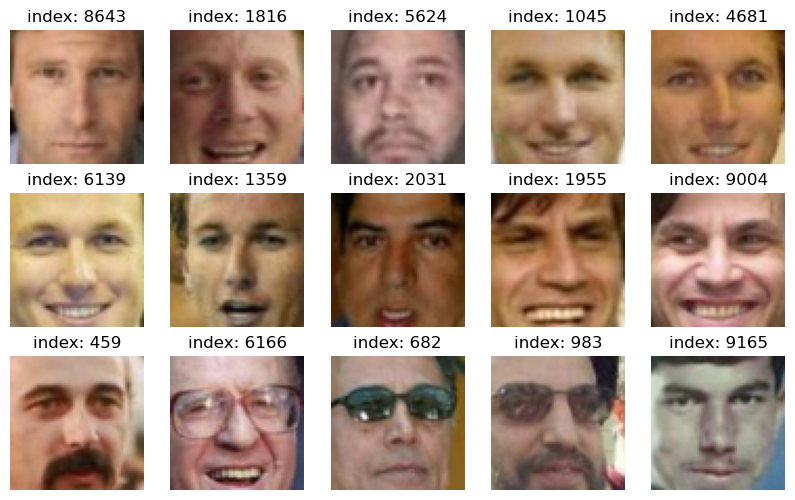

In [27]:
show_image_by_index(smiling_sample_indexes,dataset=dataset_train,plotgrid=(3,5))

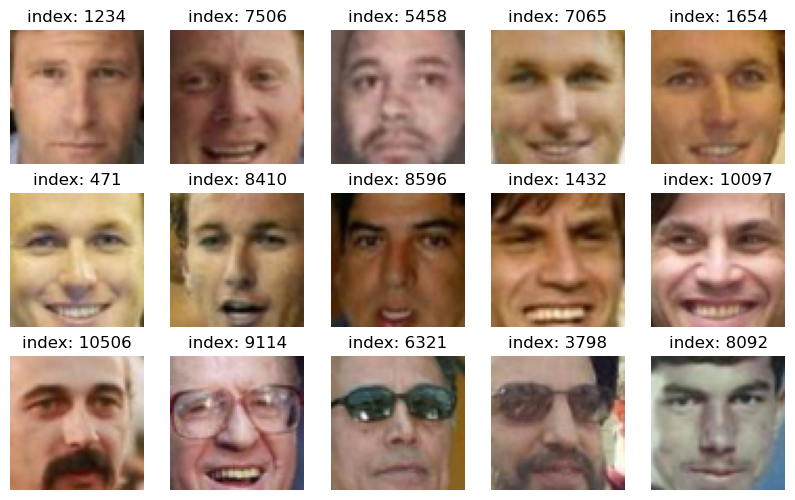

In [28]:
show_image_by_index(nosmile_sample_indexes,dataset=dataset_train,plotgrid=(3,5))

&nbsp;

#### 2. Вычисление латентных векторов

Получаем латентные векторы для весельчаков

In [29]:
def get_latent_vectors_from_index(index=0,ae=autoencoder, dataset=dataset_train):
    """
        Returns latent vectors for an object from a <dataset> with correspontend <index> 
        
        Parameters:
            index   : (int) element index
            ae      : (pytorch.nn.Module) child object
            dataset : dataset
    """

    latent_vectors = []

    with torch.no_grad():
        if type(index) != int: 
            for i in index:
                l_vector = ae.get_latent_vector(dataset.tensors[0][i])
                latent_vectors.append(l_vector)
            return latent_vectors
        else:
            l_vector = ae.get_latent_vector(dataset.tensors[0][index])
            return l_vector

In [30]:
lv = get_latent_vectors_from_index(0,ae=autoencoder,dataset=dataset_train)

In [31]:
lvs_smiling    = get_latent_vectors_from_index(smiling_sample_indexes,ae=autoencoder,dataset=dataset_train)
lvs_notsmiling = get_latent_vectors_from_index(nosmile_sample_indexes,ae=autoencoder,dataset=dataset_train)

In [32]:
len(lv)

64

&nbsp;

#### 3. Вычисление средних латентных векторов и их разности

In [34]:
lvs_smiling_n    = [lv.numpy() for lv in lvs_smiling   ] # преобразование лат. векторов из pytorch.Tensor в numpy.ndarray()
lvs_notsmiling_n = [lv.numpy() for lv in lvs_notsmiling] # преобразование лат. векторов из pytorch.Tensor в numpy.ndarray()

In [35]:
mean_smiling_vector    = np.mean(lvs_smiling_n,    axis=0) # средний латентный вектор улыбающихся
mean_notsmiling_vector = np.mean(lvs_notsmiling_n, axis=0) # средний латентный вектор не улыбающихся

smile_vector = mean_smiling_vector - mean_notsmiling_vector # получаем "вектор улыбки"

&nbsp;

#### 4. Увеселение угрюмых

In [36]:
# Получаем вектор улыбнутых людей которые раньше не улыбались
lvs_delighted = [lv_notsmiling + smile_vector for lv_notsmiling in lvs_notsmiling_n]

In [37]:
autoencoder = autoencoder.to(DEVICE)

In [38]:
imgs_delighted = []
with torch.no_grad():
    for lv in lvs_delighted:
        img = autoencoder.decoder(torch.FloatTensor(lv).to(DEVICE))
        imgs_delighted.append(img.cpu().numpy())


In [39]:
# Добавим метод отображения картинок по индексам
def show_before_after(imgs_before,imgs_after,scale=3,do_rollaxis=True,plotgrid=(2,15),max_iter=9999999):
    
    # Если на вход подали список изображений - рисуем табличку
    if type(imgs_after) == list or ( type(imgs_after) is np.ndarray and len(imgs_after.shape) == 4 ):
        n_x = plotgrid[1]
        n_y = plotgrid[0]
        plt.figure(figsize=(plotgrid[1]*scale, plotgrid[0]*scale) )
        
        if max_iter > len(imgs_before):
            max_iter = len(imgs_before)
        if max_iter > len(imgs_after):
            max_iter = len(imgs_after)
        
        if n_x*n_y < max_iter:
            n_y = int(np.ceil(len(imgs_before)/plotgrid[1]))
            
        for i in range(max_iter):
            plt.subplot(n_y, n_x, i+1)
            img = imgs_before[i]
            if do_rollaxis:
                plt.imshow( np.rollaxis(img,0,3))
            else:
                plt.imshow( img,0,3)
            plt.axis('off');
        for i in range(max_iter):
            plt.subplot(n_y, n_x, i+1+max_iter)
            img = imgs_after[i]
            if do_rollaxis:
                plt.imshow( np.rollaxis(img,0,3))
            else:
                plt.imshow( img,0,3)
            plt.axis('off');
            plt.title(f"After")    
            
    # Если на вход подали не список изображений, а одно изображение до и одно после, рисуем 2 изображения
    else:     
        plt.figure(figsize=(1,2))
        plt.subplot(1, 2, 1)
        if do_rollaxis:
            plt.imshow( np.rollaxis(imgs_before,0,3))
        else:
            plt.imshow( imgs_before,0,3)
        plt.title(f"Before")
        plt.subplot(1, 2, 2)
        if do_rollaxis:
            plt.imshow( np.rollaxis(imgs_after,0,3))
        else:
            plt.imshow( imgs_after,0,3)
        plt.axis('off');
        plt.title(f"After")
    plt.show();

С помощью списка индексов не улыбающихся получаем (из датасета) срез самих изображений, приводим так же в формату numpy.ndarray()

In [40]:
imgs_notsmiling = dataset_train.tensors[0][nosmile_sample_indexes,:,:].cpu().numpy()

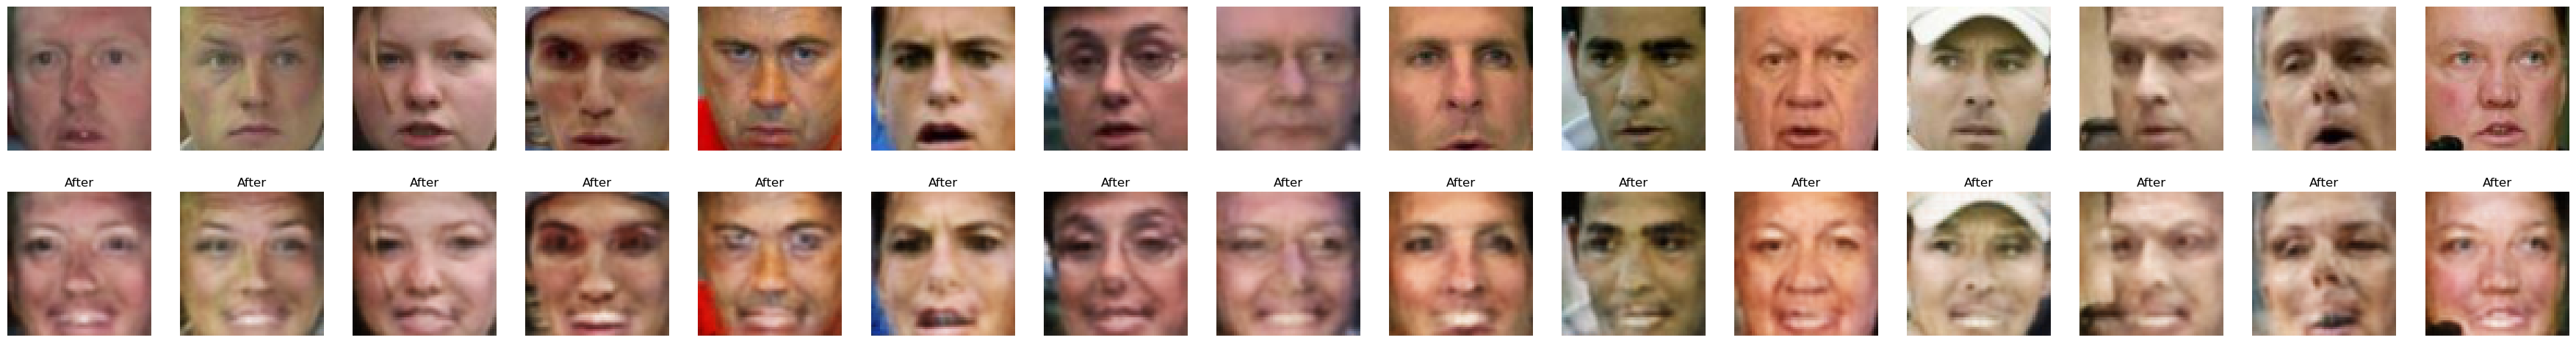

In [41]:
show_before_after(imgs_notsmiling,imgs_delighted) # рисуем до-после

Из невесёлых людей получили набор весёлых гоблинов

Вуаля! Вы восхитительны!

Теперь вы можете пририсовывать людям не только улыбки, но и много чего другого -- закрывать/открывать глаза, пририсовывать очки... в общем, все, на что хватит фантазии и на что есть атрибуты в `all_attrs`:)

# Часть 2: Variational Autoencoder (10 баллов)

Займемся обучением вариационных автоэнкодеров — проапгрейженной версии AE. Обучать будем на датасете MNIST, содержащем написанные от руки цифры от 0 до 9

In [42]:
from torchvision.transforms import v2

C:\Users\serg\anaconda3\envs\practicum\lib\site-packages\torchvision\datapoints\__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
C:\Users\serg\anaconda3\envs\practicum\lib\site-packages\torchvision\transforms\v2\__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback y

In [43]:
batch_size = 128
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True,  transform=v2.ToTensor(), download=True )
test_dataset  = datasets.MNIST(root='./mnist_data/', train=False, transform=v2.ToTensor(), download=False)
vis_dataset   = datasets.MNIST(root='./mnist_data/', train=False, transform=v2.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True )
test_loader  = torch.utils.data.DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=False)
vis_loader   = torch.utils.data.DataLoader(dataset=vis_dataset,   batch_size=batch_size, shuffle=False)

C:\Users\serg\anaconda3\envs\practicum\lib\site-packages\torchvision\transforms\v2\_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(


In [44]:
train_dataset.data.shape

torch.Size([60000, 28, 28])

In [45]:
test_dataset.data.shape

torch.Size([10000, 28, 28])

In [46]:
vis_dataset.data.shape

torch.Size([10000, 28, 28])


## 2.1 Архитектура модели и обучение (2 балла)

Реализуем VAE. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Рекомендуем пользоваться более сложными моделями, чем та, что была на семинаре:) Экспериментируйте!

In [47]:
latent_dim = 100

In [48]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1 ):
        super(ResidualBlock, self).__init__()

        padding = 1
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # Если размеры входных и выходных данных не совпадают, то нужно использовать свертку 1x1 для подгонки размерности
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.shortcut = nn.Sequential()
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        # Применение shortcut соединения
        residual = x if x.size() == out.size() else self.shortcut(x)
        out += residual
        out = self.relu(out)
        return out

In [49]:
class VAE(nn.Module):
    def __init__(self, latent_dim = 256, input_channels=1, output_channels=1, input_size=28):
        super(VAE, self).__init__()
        # <определите архитектуры encoder и decoder
        # помните, у encoder должны быть два "хвоста",
        # т.е. encoder должен кодировать картинку в 2 переменные -- mu и logsigma>
               
        self.flatten = nn.Flatten()
        self.fc_mu       = nn.Linear(256,latent_dim)
        self.fc_logsigma = nn.Linear(256,latent_dim)
        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, 16, kernel_size=3, stride=1, padding=1),   # ch 1->16
            nn.ReLU(),            
            ResidualBlock(16, 16),
            ResidualBlock(16, 16),
            ResidualBlock(16, 16),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),  # size 28->14  ch 16->32
            nn.ReLU(),
            ResidualBlock(32, 32),
            ResidualBlock(32, 32),
            ResidualBlock(32, 32),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1), # size 14->7  ch 32->64
            nn.ReLU(),
            ResidualBlock(64, 64),
            ResidualBlock(64, 64),
            ResidualBlock(64, 64),
            nn.Flatten(),
            nn.Linear(int(input_size*input_size*0.25*0.25*64), 256),
            nn.ReLU()
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256,int(input_size*input_size*0.25*0.25*64)),
            nn.ReLU(),            
            nn.Unflatten(1, (64, int(input_size*0.25),int(input_size*0.25))),
            ResidualBlock(64, 64),
            ResidualBlock(64, 64),
            ResidualBlock(64, 64),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),            
            ResidualBlock(32, 32),
            ResidualBlock(32, 32),
            ResidualBlock(32, 32),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            ResidualBlock(16, 16),
            ResidualBlock(16, 16),
            ResidualBlock(16, 16),
            nn.ConvTranspose2d(16, output_channels, kernel_size=1, stride=1, padding=0, output_padding=0),
            nn.Sigmoid()
        )
        
    def encode(self, x):
        # <реализуйте forward проход энкодера
        # в качестве ваозвращаемых переменных -- mu и logsigma>
        
        if x.device != get_model_device(self):
            x = x.to(get_model_device(self))
        
        encoded  = self.encoder(x)
        
        mu       = self.fc_mu(encoded)
        logsigma = self.fc_logsigma(encoded)
        return mu, logsigma
           

    def gaussian_sampler(self, mu, logsigma):
        if mu.device != get_model_device(self):
            mu = mu.to(get_model_device(self))
        if logsigma.device != get_model_device(self):
            logsigma = logsigma.to(get_model_device(self))
        
        if self.training:
            # <засемплируйте латентный вектор из нормального распределения с параметрами mu и sigma>
            std = torch.exp(0.5 * logsigma) # стандартное отклонение 
            eps = torch.randn_like(std)    # генерация элементов с нормальным распределением длиной в len(std) элементов
            sample = mu + (eps * std)      # приведение к заданному распределению
            return sample
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu.
            # на инференсе выход автоэнкодера должен быть детерминирован.            
            return mu

    def decode(self, z):
        # <реализуйте forward проход декодера
        # в качестве возвращаемой переменной -- reconstruction>

        if z.device != get_model_device(self):
            z = z.to(get_model_device(self))
        
        z = self.decoder(z)
        
        return z  

    def forward(self, x):
        # <используя encode и decode, реализуйте forward проход автоэнкодера
        # в качестве ваозвращаемых переменных -- mu, logsigma и reconstruction>
        if x.device != get_model_device(self):
            x = x.to(get_model_device(self))
        
        # encoding
        mu, logsigma = self.encode(x)

        z = self.gaussian_sampler(mu,logsigma)
 
        # decoding    
        reconstruction = self.decode(z)

        return mu, logsigma, reconstruction

Определим лосс и его компоненты для VAE:

Надеюсь, вы уже прочитали материал в towardsdatascience (или еще где-то) про VAE и знаете, что лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [50]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    loss = -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp())
    return loss

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    """
    #loss = <binary cross-entropy>
    
    loss = nn.BCELoss(reduction='sum')
    
    return loss(reconstruction, x)

def loss_vae(x, mu, logsigma, reconstruction):
    return KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)

И обучим модель:

In [51]:
criterion = loss_vae

autoencoder = VAE(latent_dim=latent_dim,input_channels=1,output_channels=1,input_size=28)

optimizer = torch.optim.Adam(autoencoder.parameters(),lr=1e-4) #<Ваш любимый оптимизатор>

In [52]:
n_epochs     = 20
train_losses = []
val_losses   = []

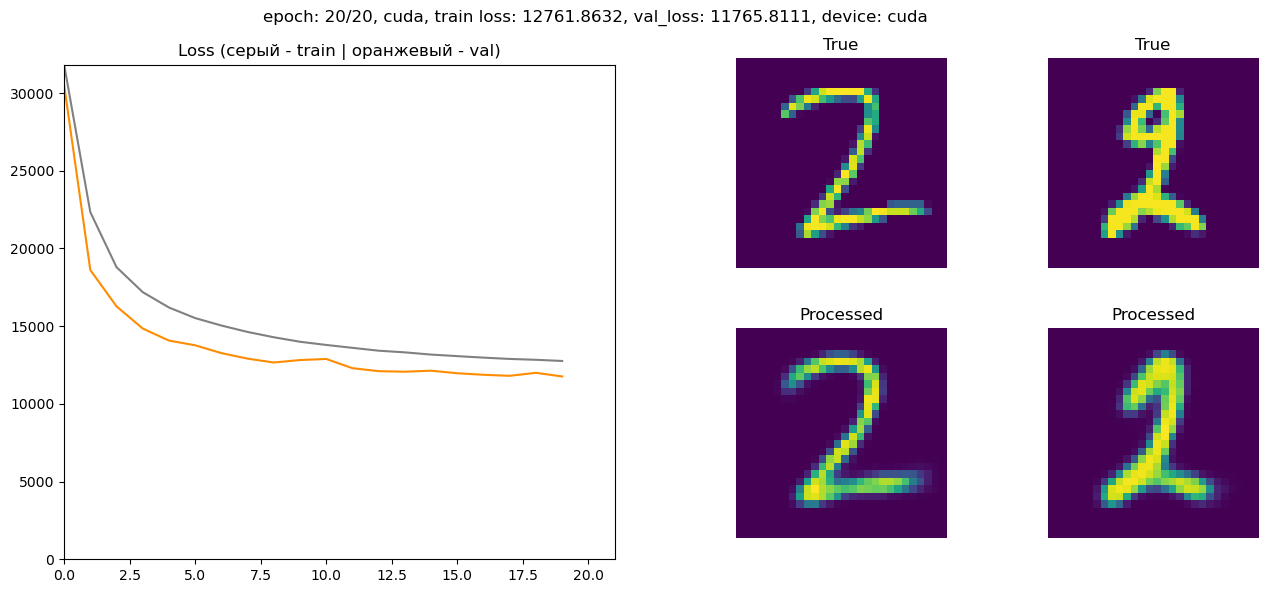

CPU times: total: 8min 54s
Wall time: 8min 54s


In [53]:
%%time
#<обучите модель на датасете MNIST>
max_error = 0

# <тут Ваш код тренировки автоэнкодера>
device = DEVICE

autoencoder = autoencoder.cpu()
torch.cuda.empty_cache()

autoencoder = autoencoder.to(device)
visloader_enumerator = iter(vis_loader)

for e in tqdm( range(1,n_epochs+1) , desc='epoch',leave=False, position = 0):

    # ОБУЧЕНИЕ
    
    autoencoder.train()
    train_losses_per_epoch = []
    i = 0
    n = len(train_dataset.data)
    for batch_data in tqdm(train_loader, desc='batch',leave=False, position = 1):
        batch = batch_data[0]
        optimizer.zero_grad()
        mu_train, logsigma_train, reconstruction_train = autoencoder(batch.to(device))
        loss = criterion(batch.to(device).float(), mu_train, logsigma_train, reconstruction_train)
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())

    mean_train_loss = np.mean(train_losses_per_epoch)
    train_losses.append(mean_train_loss)
    if mean_train_loss > max_error:
        max_error = mean_train_loss

    # ВАЛИДАЦИЯ
    
    autoencoder.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for batch_data_val in test_loader:
            batch_val = batch_data_val[0]
            mu_val, logsigma_val, reconstruction_val = autoencoder(batch_val.to(device))
            loss = criterion(batch_val.to(device).float(), mu_val, logsigma_val, reconstruction_val)
            val_losses_per_epoch.append(loss.item())

    mean_val_loss = np.mean(val_losses_per_epoch)
    val_losses.append(mean_val_loss)
    if mean_val_loss > max_error:
        max_error = mean_val_loss

    # Визуализация
    autoencoder.eval()  # testing mode
    images_vis = next(visloader_enumerator)
    x_images_vis = images_vis[0].to(DEVICE)
    mu_vis, logsigma_vis, reconstruction_vis = autoencoder(x_images_vis.to(device))
    y_images_vis = reconstruction_vis.detach().cpu()
    x_images_vis = x_images_vis.cpu()
    clear_output(wait=True)

    ##################################################################
    # Отприсовка графиков ошибок и примеров обработанных изображений #
    ##################################################################

    # Определение размера фигуры
    fig = plt.figure(figsize=(12, 6))

    # Создание графика функции с заданным соотношением размеров
    ax1 = fig.add_subplot(121)
    ax1.plot(train_losses, label="Train loss"     ,color='gray')
    ax1.plot(val_losses,   label="Validation loss",color='darkorange')
    ax1.set_xlim(0,n_epochs+1)
    ax1.set_ylim(0,max_error)
    ax1.set_title("Loss (серый - train | оранжевый - val)")

    # Определение позиций для изображений
    # Прямоугольник: [x, y, width, height]
    base_width, base_height = 0.35, 0.35  # Увеличены на 25%

    image_positions = [(0.53, 0.55, base_width, base_height),  # Вычитаем (0.25 * height)/2 из y для компенсации
                       (0.79, 0.55, base_width, base_height),  # Высота изображений корректирована также
                       (0.53, 0.1, base_width, base_height),
                       (0.79, 0.1, base_width, base_height)]

    # Итерация для создания изображений
    for idx, pos in enumerate(image_positions):
        ax = fig.add_axes(pos)

        if idx == 0:
            ax.imshow(np.rollaxis(x_images_vis[0].numpy(), 0, 3))  
            ax.set_title(f"True")
        if idx == 1:
            ax.imshow(np.rollaxis(x_images_vis[1].numpy(), 0, 3))  
            ax.set_title(f"True")
        if idx == 2:
            ax.imshow(np.rollaxis(y_images_vis[0].numpy(), 0, 3))  
            ax.set_title(f"Processed")
        if idx == 3:
            ax.imshow(np.rollaxis(y_images_vis[1].numpy(), 0, 3))  
            ax.set_title(f"Processed")

        # Удаление осей для изображения
        ax.axis('off')

    plt.suptitle(f"epoch: {e}/{n_epochs}, {device}, train loss: {mean_train_loss:.4f}, val_loss: {mean_val_loss:.4f}, device: {DEVICE}")

    plt.tight_layout()
    plt.show()
        
autoencoder = autoencoder.cpu()
torch.cuda.empty_cache()
        

In [54]:
tprint('VAE обучен')

VAE обучен


Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

In [55]:
# < тут Ваш код: выведите первые Х картинок и их реконструкций из val выборки на экран>

In [56]:
valloader_enumerator = iter(test_loader)

autoencoder = autoencoder.to(DEVICE)
autoencoder.eval()  # testing mode
images_val = next(valloader_enumerator)
x_images_val = images_val[0].to(DEVICE)
_, _, reconstruction_val = autoencoder(x_images_val.to(device))
y_images_val = reconstruction_val.detach().cpu()
x_images_val = x_images_val.cpu()

In [57]:
x_images_val_numpy = x_images_val.numpy()
y_images_val_numpy = y_images_val.numpy()

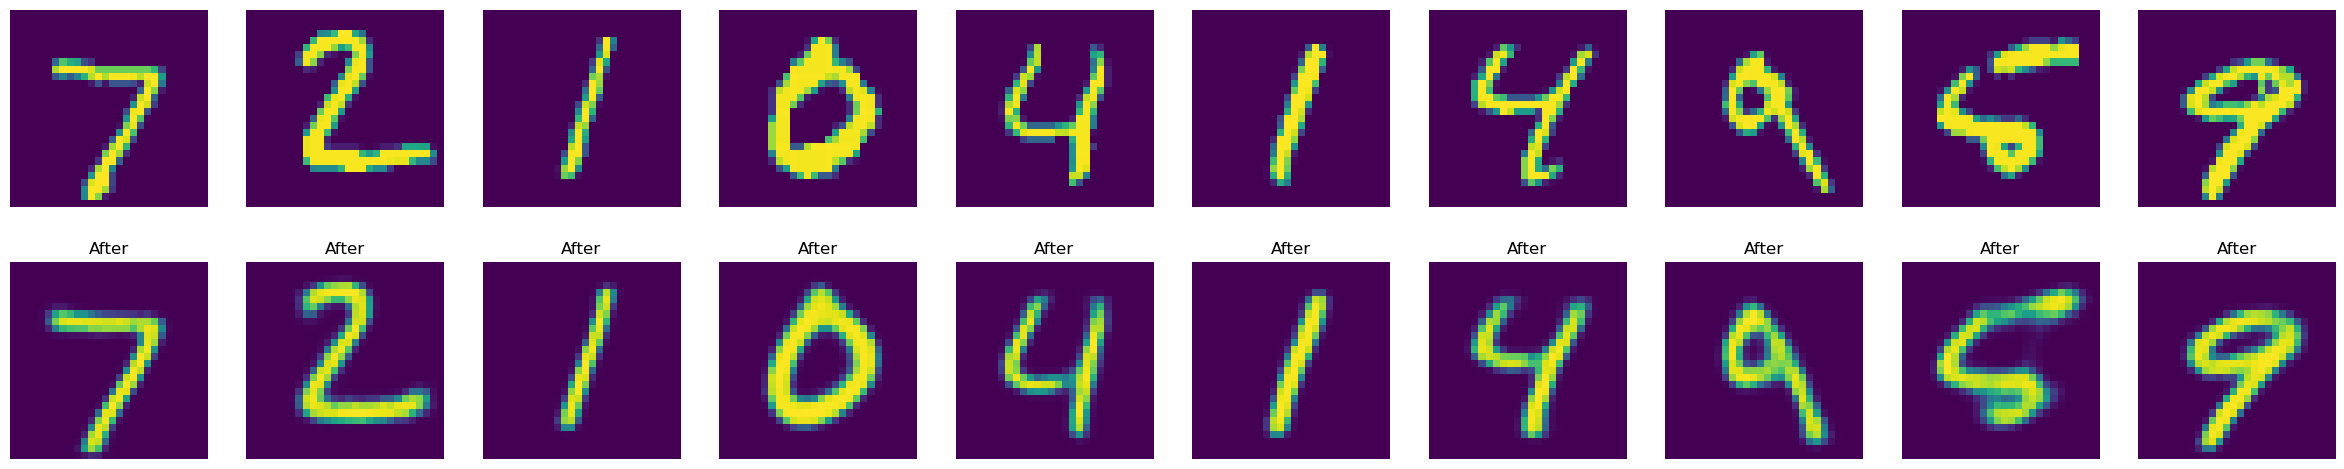

In [58]:
show_before_after(x_images_val_numpy, y_images_val_numpy,plotgrid=(2,10),max_iter=10)

&nbsp;

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

In [59]:
# вспомните про замечание из этого же пункта обычного AE про распределение латентных переменных
z = np.array([np.random.normal(0, 1, 100) for i in range(10)])
z = torch.FloatTensor(z)

In [60]:
# <скормите z декодеру>

autoencoder.eval()
autoencoder = autoencoder.to(DEVICE)

generated = autoencoder.decode(z.to(DEVICE)).cpu().detach().numpy()
autoencoder = autoencoder.cpu()
torch.cuda.empty_cache()

In [ ]:
# <выведите тут полученные картинки>

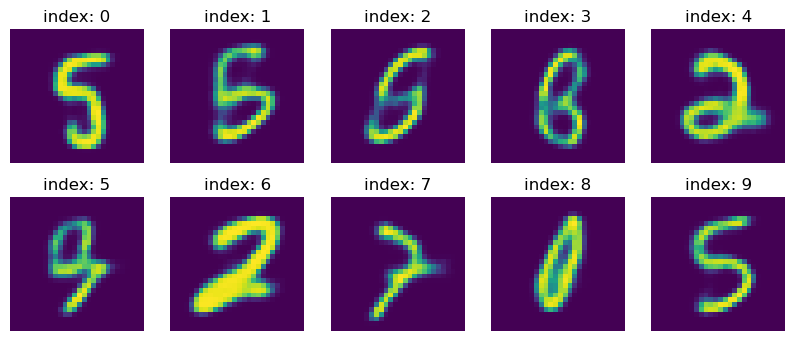

In [61]:
show_image_by_index(range(len(z)),generated,plotgrid=(2,5))

&nbsp;

## 2.2. Latent Representation (2 балла)

Давайте посмотрим, как латентные векторы картинок лиц выглядят в пространстве.
Ваша задача -- изобразить латентные векторы картинок точками в двумерном просторанстве.

Это позволит оценить, насколько плотно распределены латентные векторы изображений цифр в пространстве.

Плюс давайте сделаем такую вещь: покрасим точки, которые соответствуют картинкам каждой цифры, в свой отдельный цвет

Подсказка: красить -- это просто =) У plt.scatter есть параметр c (color), см. в документации.


Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощтю `TSNE` (есть в `sklearn`) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью `matplotlib.scatter`, покрасить разными цветами точки, соответствующие картинкам разных цифр.

In [62]:
from sklearn.manifold import TSNE

In [63]:
# <ваш код получения латентных представлений, применения TSNE и визуализации>

In [65]:
# Получение латентных представлений для датасета
def get_latent_representations(vae_model, loader):
    vae_model.eval()
    latent_representations = []
    labels_arr = []
    i = 0
    
    with torch.no_grad():
        for data in tqdm(loader, desc='batch',leave=False, position = 0):
            if len(data) == 1:
                inputs = data[0]
            else:
                inputs, labels = data
                
            mu, logvar = vae_model.encode(inputs.to(get_model_device(vae_model)))            
            z = vae_model.gaussian_sampler(mu, logvar)
            latent_representations.append(z)
            
            if len(data) == 2:
                labels_arr.append(labels)
            i+=1
    if len(data) == 2:
        labels_list = [int(item.detach().cpu().numpy()) for sublist in labels_arr for item in sublist]
        return torch.cat(latent_representations,dim=0).detach().cpu().numpy()          ,labels_list
    else:
        return torch.cat(latent_representations,dim=0).detach().cpu().numpy()

In [66]:
autoencoder = autoencoder.to(DEVICE)
    
latent_representation, labels_list = get_latent_representations(autoencoder,test_loader)

batch:   0%|          | 0/79 [00:00<?, ?it/s]

In [67]:
# Создаем экземпляр объекта t-SNE
tsne = TSNE(n_components=2, random_state=SEED)

# Применяем t-SNE к латентным представлениям
latent_tsne = tsne.fit_transform(latent_representation)

In [68]:
colors = ['blue', 'cyan', 'green', 'yellow', 'orange', 'red', 'magenta', 'purple', 'brown', 'pink']
label_colors = [colors[l] for l in labels_list]

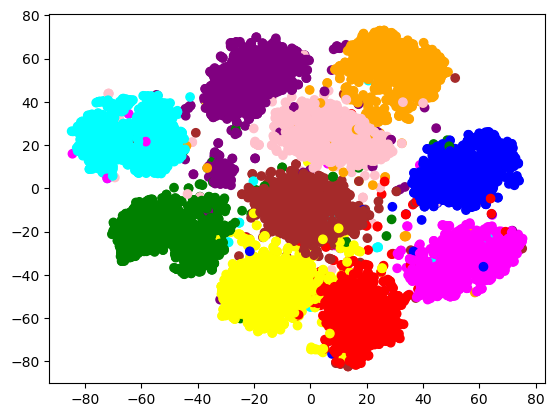

In [69]:
plt.scatter(latent_tsne[:, 0], latent_tsne[:, 1],c=label_colors)
plt.show()

Что вы думаете о виде латентного представления?

<b>Вывод</b>: Вид латентного представления хорошо визуализирует выраженные отличия смысла изображений с соответствующими цифрами

&nbsp;

__Congrats v2.0!__

&nbsp;

## 2.3. Conditional VAE (6 баллов)


Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер.
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица).
И вот нам понадобилось сгенерировать цифру 8, и мы подставляем разные варианты шума, но восьмерка никак не генерится:(

Хотелось бы добавить к нашему AE функцию "выдай мне рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).  Conditional AE — так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части задания мы научимся такие обучать.

### Архитектура

На картинке ниже представлена архитектура простого Conditional VAE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки.

То есть, в первый (входной) слой энкодера подается конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). В первый слой декодера подается конкатенация латентного вектора и информации о классе.


![alt text](https://sun9-63.userapi.com/impg/Mh1akf7mfpNoprrSWsPOouazSmTPMazYYF49Tw/djoHNw_9KVA.jpg?size=1175x642&quality=96&sign=e88baec5f9bb91c8443fba31dcf0a4df&type=album)

![alt text](https://sun9-73.userapi.com/impg/UDuloLNKhzTBYAKewgxke5-YPsAKyGOqA-qCRg/MnyCavJidxM.jpg?size=1229x651&quality=96&sign=f2d21bfacc1c5755b76868dc4cfef39c&type=album)



На всякий случай: это VAE, то есть, latent у него все еще состоит из mu и sigma

Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

P.S. Также можно передавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

In [70]:
class CVAE(nn.Module):
    def __init__(self, latent_dim = 256, input_channels=1, output_channels=1, input_size=28, num_classes=10, use_labels=False):
        super(CVAE, self).__init__()
        # <определите архитектуры encoder и decoder
        # помните, у encoder должны быть два "хвоста",
        # т.е. encoder должен кодировать картинку в 2 переменные -- mu и logsigma>
        
        self.num_classes = num_classes
        self.use_labels  = use_labels
        self.flatten = nn.Flatten()
        self.fc_mu       = nn.Linear(256,latent_dim)
        self.fc_logsigma = nn.Linear(256,latent_dim)
        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, 16, kernel_size=3, stride=1, padding=1),   # ch 1->16
            nn.ReLU(),            
            ResidualBlock(16, 16),
            ResidualBlock(16, 16),
            ResidualBlock(16, 16),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),  # size 28->14  ch 16->32
            nn.ReLU(),
            ResidualBlock(32, 32),
            ResidualBlock(32, 32),
            ResidualBlock(32, 32),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1), # size 14->7  ch 32->64
            nn.ReLU(),
            ResidualBlock(64, 64),
            ResidualBlock(64, 64),
            ResidualBlock(64, 64),
            nn.Flatten(),
            nn.Linear(int(input_size*input_size*0.25*0.25*64), 256),
            nn.ReLU()
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            # Если используем метки то на вход декодеру добавляем число нейронов,
            # соответствующее числу OHE-признаков (num_classes)
            nn.Linear(latent_dim + int(use_labels)*num_classes, 256),
            nn.ReLU(),
            nn.Linear(256,int(input_size*input_size*0.25*0.25*64)),
            nn.ReLU(),            
            nn.Unflatten(1, (64, int(input_size*0.25),int(input_size*0.25))),
            ResidualBlock(64, 64),
            ResidualBlock(64, 64),
            ResidualBlock(64, 64),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),            
            ResidualBlock(32, 32),
            ResidualBlock(32, 32),
            ResidualBlock(32, 32),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            ResidualBlock(16, 16),
            ResidualBlock(16, 16),
            ResidualBlock(16, 16),
            nn.ConvTranspose2d(16, output_channels, kernel_size=1, stride=1, padding=0, output_padding=0),
            nn.Sigmoid()
        )

    def encode(self, x): #, class_num):  
        # <реализуйте forward проход энкодера
        # в качестве ваозвращаемых переменных -- mu, logsigma и класс картинки>
    
        # В моей реализации метка класса нужна только в декодере, так как задача энкодера - генерировать 
        # распределение, а не объекты. А распределение создается и без меток. 
        # Метки я буду добавлять при подаче в декодер
        
        if x.device != get_model_device(self):
            x = x.to(get_model_device(self))
           
        encoded  = self.encoder(x)        
        
        mu       = self.fc_mu(encoded)
        logsigma = self.fc_logsigma(encoded)

        return mu, logsigma

    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            # <засемплируйте латентный вектор из нормального распределения с параметрами mu и sigma>
            std = torch.exp(0.5 * logsigma) # стандартное отклонение 
            eps = torch.randn_like(std)    # генерация элементов с нормальным распределением длиной в len(std) элементов
            sample = mu + (eps * std)      # приведение к заданному распределению
            return sample
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu.
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu

    def decode(self, z, class_num=0):
        # <реализуйте forward проход декодера
        # в качестве возвращаемой переменной -- reconstruction>
        
        if self.use_labels:
            if type(class_num) != torch.Tensor:
                class_num = torch.tensor(class_num).to( get_model_device(self) )
            else:
                if class_num.device!=get_model_device(self):
                    class_num = class_num.to(get_model_device(self))            
            class_ohe = F.one_hot(class_num, num_classes = self.num_classes)    
            
            if z.device!=get_model_device(self):
                z = z.to(get_model_device(self))
            
            concatenated_vector = torch.cat([z, class_ohe], dim=1)            
            reconstruction = self.decoder( concatenated_vector )            
        else:
            reconstruction = self.decoder(z)            
        return reconstruction
    

    def forward(self, x, class_num=0):
        # <используя encode и decode, реализуйте forward проход автоэнкодера
        # в качестве ваозвращаемых переменных -- mu, logsigma и reconstruction>

        if x.device != get_model_device(self):
            x = x.to(get_model_device(self))
    
        # encoding
        mu, logsigma = self.encode(x)

        z = self.gaussian_sampler(mu, logsigma)
 
        # decoding    
        reconstruction = self.decode(z, class_num)

        return mu, logsigma, reconstruction

In [71]:
criterion = loss_vae

model = CVAE(latent_dim=latent_dim, input_channels=1, output_channels=1, input_size=28,num_classes=10,use_labels = True)

optimizer = torch.optim.Adam(model.parameters(),lr=1e-4) #<Ваш любимый оптимизатор>

In [72]:
n_epochs     = 20
train_losses = []
val_losses   = []

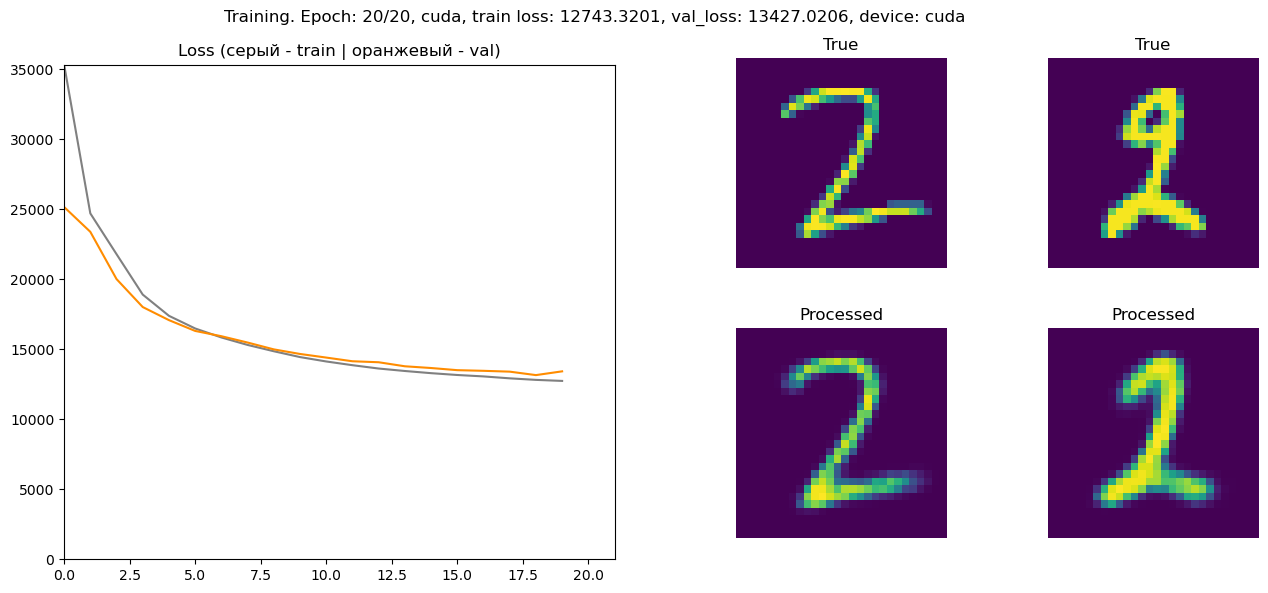

CPU times: total: 8min 56s
Wall time: 8min 56s


In [73]:
%%time
#<обучите модель на датасете MNIST>
max_error = 0

# <тут Ваш код тренировки автоэнкодера>
device = DEVICE

model = model.cpu()
torch.cuda.empty_cache()

model = model.to(device)
visloader_enumerator = iter(vis_loader)

for e in tqdm( range(1,n_epochs+1) , desc='epoch',leave=False, position = 0):

    # ОБУЧЕНИЕ    
    model.train()
    train_losses_per_epoch = []
    i = 0
    n = len(train_dataset.data)
    for x_batch, y_batch in tqdm(train_loader, desc='batch',leave=False, position = 1):
        optimizer.zero_grad()
        mu_train, logsigma_train, reconstruction_train = model(x_batch.to(device), y_batch.to(device))
        loss = criterion(x_batch.to(device).float(), mu_train, logsigma_train, reconstruction_train)
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())

    mean_train_loss = np.mean(train_losses_per_epoch)
    train_losses.append(mean_train_loss)
    if mean_train_loss > max_error:
        max_error = mean_train_loss

    # ВАЛИДАЦИЯ
    
    autoencoder.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            mu_val, logsigma_val, reconstruction_val = model(x_batch.to(device), y_batch.to(device))
            loss = criterion(x_batch.to(device).float(), mu_val, logsigma_val, reconstruction_val)
            val_losses_per_epoch.append(loss.item())

    mean_val_loss = np.mean(val_losses_per_epoch)
    val_losses.append(mean_val_loss)
    if mean_val_loss > max_error:
        max_error = mean_val_loss

    # Визуализация
    model.eval()  # testing mode
    images_vis = next(visloader_enumerator)
    x_images_vis = images_vis[0].to(DEVICE)
    y_images_vis = images_vis[1].to(DEVICE)
    mu_vis, logsigma_vis, reconstruction_vis = model(x_images_vis.to(device),y_images_vis.to(device))
    y_images_vis = reconstruction_vis.detach().cpu()
    x_images_vis = x_images_vis.cpu()
    clear_output(wait=True)

    ##################################################################
    # Отприсовка графиков ошибок и примеров обработанных изображений #
    ##################################################################

    # Определение размера фигуры
    fig = plt.figure(figsize=(12, 6))

    # Создание графика функции с заданным соотношением размеров
    ax1 = fig.add_subplot(121)
    ax1.plot(train_losses, label="Train loss"     ,color='gray')
    ax1.plot(val_losses,   label="Validation loss",color='darkorange')
    ax1.set_xlim(0,n_epochs+1)
    ax1.set_ylim(0,max_error)
    ax1.set_title("Loss (серый - train | оранжевый - val)")

    # Определение позиций для изображений
    # Прямоугольник: [x, y, width, height]
    base_width, base_height = 0.35, 0.35  # Увеличены на 25%

    image_positions = [(0.53, 0.55, base_width, base_height),  # Вычитаем (0.25 * height)/2 из y для компенсации
                       (0.79, 0.55, base_width, base_height),  # Высота изображений корректирована также
                       (0.53, 0.1, base_width, base_height),
                       (0.79, 0.1, base_width, base_height)]

    # Итерация для создания изображений
    for idx, pos in enumerate(image_positions):
        ax = fig.add_axes(pos)

        if idx == 0:
            ax.imshow(np.rollaxis(x_images_vis[0].numpy(), 0, 3))  
            ax.set_title(f"True")
        if idx == 1:
            ax.imshow(np.rollaxis(x_images_vis[1].numpy(), 0, 3))  
            ax.set_title(f"True")
        if idx == 2:
            ax.imshow(np.rollaxis(y_images_vis[0].numpy(), 0, 3))  
            ax.set_title(f"Processed")
        if idx == 3:
            ax.imshow(np.rollaxis(y_images_vis[1].numpy(), 0, 3))  
            ax.set_title(f"Processed")

        # Удаление осей для изображения
        ax.axis('off')

    plt.suptitle(f"Training. Epoch: {e}/{n_epochs}, {device}, train loss: {mean_train_loss:.4f}, val_loss: {mean_val_loss:.4f}, device: {DEVICE}")

    plt.tight_layout()
    plt.show()
        
model = model.cpu()
torch.cuda.empty_cache()
        

In [74]:
tprint('ok')

ok


### Sampling


Тут мы будем сэмплировать из CVAE. Это прикольнее, чем сэмплировать из простого AE/VAE: тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов!
Для MNIST вы можете попросить CVAE восстановить из одного латентного вектора, например, картинки цифры 5 и 7.

In [75]:
#<тут нужно научиться сэмплировать из декодера цифры определенного класса>

labels_list = [j for i in range(10) for j in range(10)] # семплируем каждую цифру из 0..9 по 10 раз
n_labels = len(labels_list)

In [76]:
model.eval()  # testing mode

x_images_vis = images_vis[0].to(DEVICE)
y_images_vis = images_vis[1].to(DEVICE)

# Делаем два вектора
z = model.gaussian_sampler(mu_vis, logsigma_vis)[:n_labels]

pred_images_vis = model.decode(z,labels_list)

pred_images_vis = pred_images_vis.detach().cpu()
x_images_vis = x_images_vis.cpu()

pred_images_vis = pred_images_vis.cpu().detach().numpy()

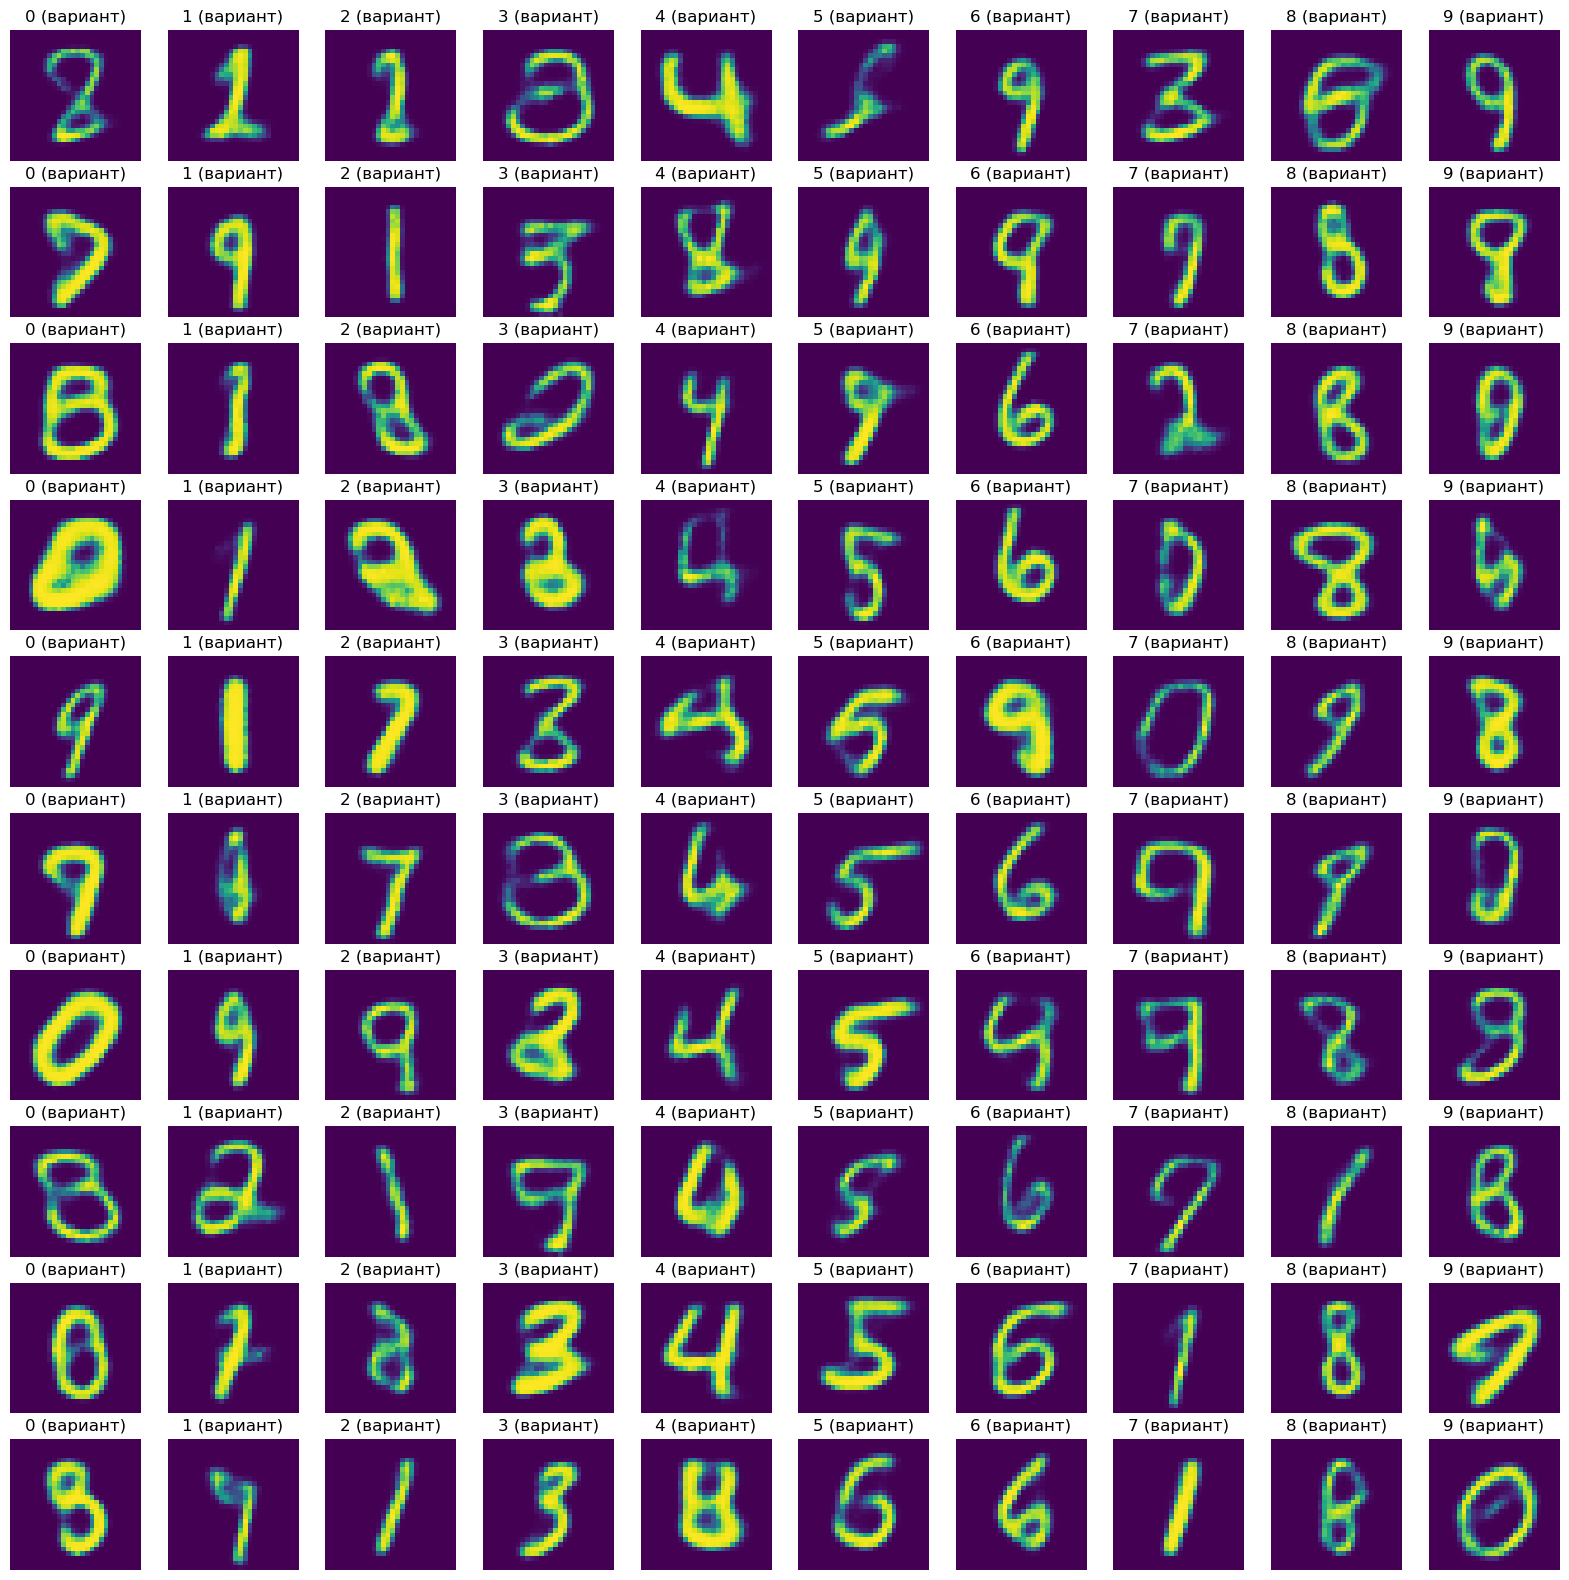

In [77]:
rows = n_labels//10
cols = n_labels if n_labels < 10 else 10
show_image_by_index(labels_list,pred_images_vis,plotgrid=(rows,cols),prefix="",postfix=" (вариант)")

Splendid! Вы великолепны!


&nbsp;

### Latent Representations

Давайте посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE =)

Опять же, нужно покрасить точки в разные цвета в зависимости от класса.

In [78]:
#<ваш код получения латентных представлений, применения TSNE и визуализации>

In [79]:
latent_representation_cvae, labels_list_cvae = get_latent_representations(model,test_loader)

batch:   0%|          | 0/79 [00:00<?, ?it/s]

In [80]:
# Создаем экземпляр объекта t-SNE
tsne_cvae = TSNE(n_components=2, random_state=SEED)

# Применяем t-SNE к латентным представлениям
latent_tsne_cvae = tsne_cvae.fit_transform(latent_representation_cvae)

In [81]:
colors_cvae = ['blue', 'cyan', 'green', 'yellow', 'orange', 'red', 'magenta', 'purple', 'brown', 'pink']
label_colors_cvae = [colors_cvae[l] for l in labels_list_cvae]

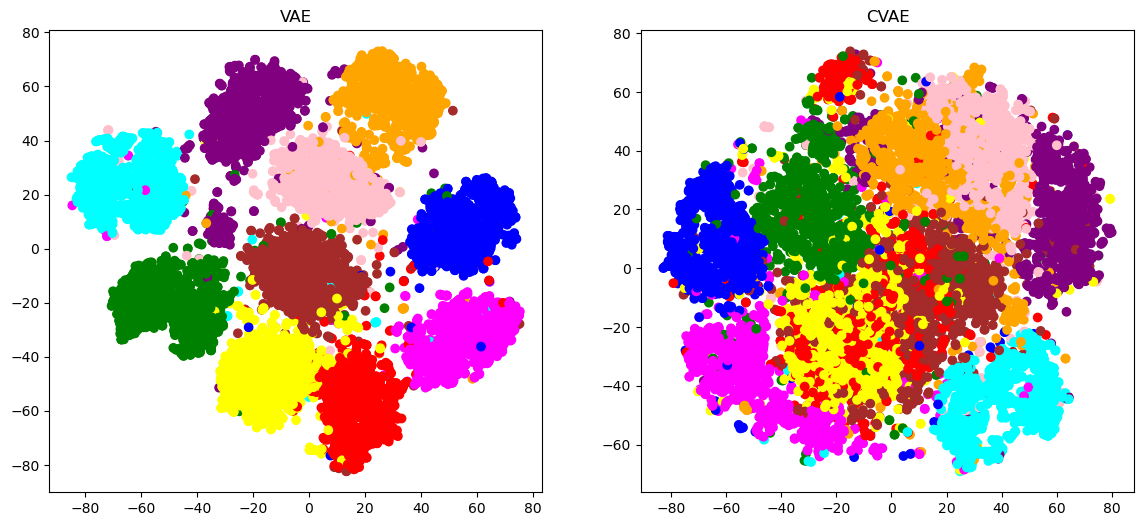

In [82]:
# Создание сетки из двух графиков
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Размещение первого графика слева
axs[0].scatter(latent_tsne[:, 0], latent_tsne[:, 1],c=label_colors)
axs[0].set_title('VAE')

# Размещение второго графика справа
axs[1].scatter(latent_tsne_cvae[:, 0], latent_tsne_cvae[:, 1],c=label_colors_cvae)
axs[1].set_title('CVAE')

# Отображение графиков
plt.show()

Что вы думаете насчет этой картинки? Отличается от картинки для VAE?

<B>Вывод</B>: &nbsp;&nbsp;Да, пожалуй разница весьма ощутима, выглядит так будт в латентном пространстве, сформированном CVAE меньше "контрастности", классы сильнее перемешаны

# BONUS 1: Denoising

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

У автоэнкодеров, кроме сжатия и генерации изображений, есть другие практические применения. Про одно из них эта бонусная часть задания.

Автоэнкодеры могут быть использованы для избавления от шума на фотографиях (denoising). Для этого их нужно обучить специальным образом: input картинка будет зашумленной, а выдавать автоэнкодер должен будет картинку без шума.
То есть, loss-функция AE останется той же (MSE между реальной картинкой и выданной), а на вход автоэнкодеру будет подаваться зашумленная картинка.

<a href="https://ibb.co/YbRJ1nZ"><img src="https://i.ibb.co/0QD164t/Screen-Shot-2020-06-04-at-4-49-50-PM.png" alt="Screen-Shot-2020-06-04-at-4-49-50-PM" border="0"></a>

Для этого нужно взять ваш любимый датасет (датасет лиц из первой части этого задания или любой другой) и сделать копию этого датасета с шумом.

В питоне шум можно добавить так:

In [84]:
# <тут ваш код обучения автоэнкодера на зашумленных картинках. Не забудтье разбить на train/test!>

In [86]:
def add_noise(batch : torch.Tensor, noise_level=0.2):
    # Добавление шума к исходному тензору с учетом коэффициента шума
    return batch + noise_level * torch.randn_like(batch)

In [87]:
data, attrs = fetch_dataset()
n_objs = len(data) 

imgs_train, imgs_val, attr_train, attr_val = train_test_split(data,attrs, test_size=0.2, shuffle=False) 


imgs_train = torch.FloatTensor(np.rollaxis(imgs_train, 3, 1))
imgs_val   = torch.FloatTensor(np.rollaxis(imgs_val,   3, 1))

dataset_train = TensorDataset(imgs_train)
dataset_val   = TensorDataset(imgs_val  )

train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=32,shuffle=False)
val_loader   = torch.utils.data.DataLoader(dataset_val,   batch_size=32,shuffle=False)
vis_loader   = torch.utils.data.DataLoader(dataset_val,   batch_size=32,shuffle=True)

In [88]:
criterion      = loss_vae
model_denoiser = VAE(latent_dim=latent_dim, input_channels=imgs_train.shape[1], output_channels=imgs_train.shape[1], input_size=imgs_train.shape[-1])
optimizer      = torch.optim.Adam(model_denoiser.parameters(),lr=1e-4) #<Ваш любимый оптимизатор>

In [89]:
n_epochs     = 20
train_losses = []
val_losses   = []

In [90]:
min_noise_factor = 0
max_noise_factor = 0.15

In [85]:
# <тут проверка, как AE убирает шум с тестовых картинок. Надеюсь, все получилось =)>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


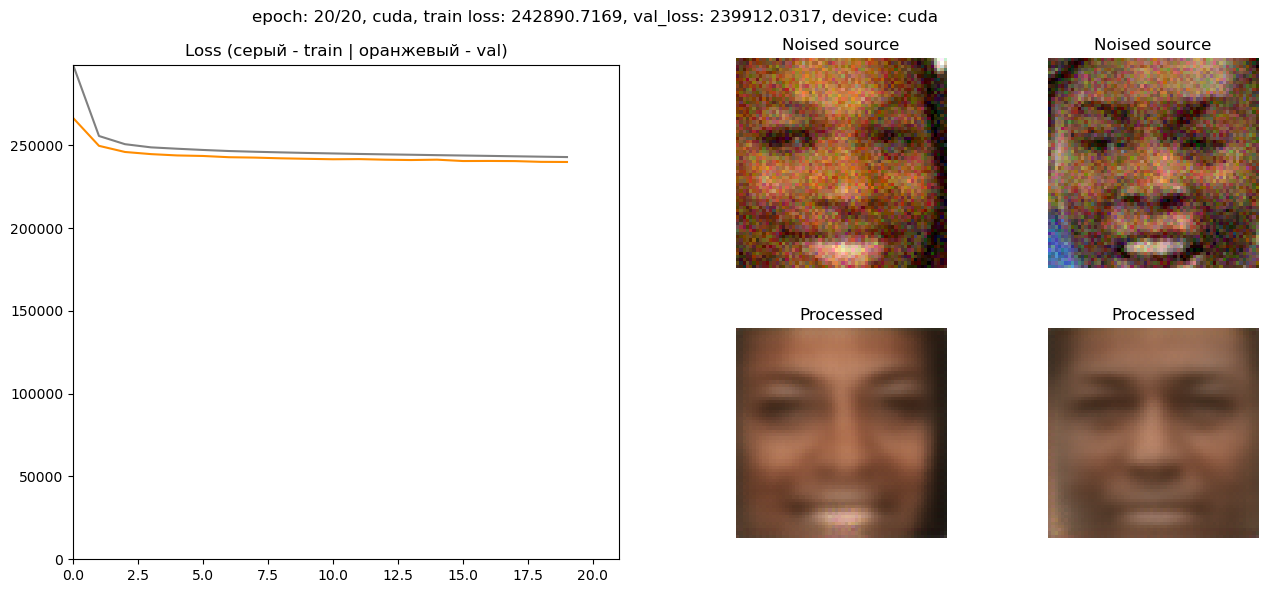

CPU times: total: 2min 47s
Wall time: 2min 22s


In [91]:
%%time
max_error = 0
device = DEVICE

model_denoiser = model_denoiser.cpu()
torch.cuda.empty_cache()

model_denoiser = model_denoiser.to(device)
visloader_enumerator = iter(vis_loader)

for e in tqdm( range(1,n_epochs+1) , desc='epoch',leave=False, position = 0):
    # ОБУЧЕНИЕ
    
    model_denoiser.train()
    train_losses_per_epoch = []
    i = 0
    n = len(train_dataset.data)
    for batch_data in tqdm(train_loader, desc='batch',leave=False, position = 1):
        batch = batch_data[0]
        noise_level = random.uniform(min_noise_factor,max_noise_factor)
        noised_image = add_noise(batch,noise_level=noise_level)
        optimizer.zero_grad()
        mu_train, logsigma_train, reconstruction_train = model_denoiser(noised_image.to(device))
        loss = criterion(batch.to(device).float(), mu_train, logsigma_train, reconstruction_train)
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())

    mean_train_loss = np.mean(train_losses_per_epoch)
    train_losses.append(mean_train_loss)
    if mean_train_loss > max_error:
        max_error = mean_train_loss

    # ВАЛИДАЦИЯ
    
    model_denoiser.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for batch_data_val in val_loader:
            batch_val = batch_data_val[0]
            noise_level = random.uniform(min_noise_factor,max_noise_factor)
            noised_image = add_noise(batch_val,noise_level=noise_level)
            mu_val, logsigma_val, reconstruction_val = model_denoiser(noised_image.to(device))
            loss = criterion(batch_val.to(device).float(), mu_val, logsigma_val, reconstruction_val)
            val_losses_per_epoch.append(loss.item())

    mean_val_loss = np.mean(val_losses_per_epoch)
    val_losses.append(mean_val_loss)
    if mean_val_loss > max_error:
        max_error = mean_val_loss

    # Визуализация
    model_denoiser.eval()  # testing mode
    images_vis = next(visloader_enumerator)
    x_images_vis = images_vis[0].to(DEVICE)
    
    noise_level = random.uniform(min_noise_factor,max_noise_factor)
    noised_image = add_noise(x_images_vis,noise_level=noise_level)
    
    mu_vis, logsigma_vis, reconstruction_vis = model_denoiser(noised_image.to(device))
    y_images_vis = reconstruction_vis.detach().cpu()
    x_images_vis = x_images_vis.cpu()
    noised_image = noised_image.detach().cpu()
    clear_output(wait=True)
    ##################################################################
    # Отприсовка графиков ошибок и примеров обработанных изображений #
    ##################################################################

    # Определение размера фигуры
    fig = plt.figure(figsize=(12, 6))

    # Создание графика функции с заданным соотношением размеров
    ax1 = fig.add_subplot(121)
    ax1.plot(train_losses, label="Train loss"     ,color='gray')
    ax1.plot(val_losses,   label="Validation loss",color='darkorange')
    ax1.set_xlim(0,n_epochs+1)
    ax1.set_ylim(0,max_error)
    ax1.set_title("Loss (серый - train | оранжевый - val)")

    # Определение позиций для изображений
    # Прямоугольник: [x, y, width, height]
    base_width, base_height = 0.35, 0.35  # Увеличены на 25%

    image_positions = [(0.53, 0.55, base_width, base_height),  # Вычитаем (0.25 * height)/2 из y для компенсации
                       (0.79, 0.55, base_width, base_height),  # Высота изображений корректирована также
                       (0.53, 0.1, base_width, base_height),
                       (0.79, 0.1, base_width, base_height)]

    # Итерация для создания изображений
    for idx, pos in enumerate(image_positions):
        ax = fig.add_axes(pos)

        if idx == 0:
            ax.imshow(np.rollaxis(noised_image[0].numpy(), 0, 3))  
            ax.set_title(f"Noised source")
        if idx == 1:
            ax.imshow(np.rollaxis(noised_image[1].numpy(), 0, 3))  
            ax.set_title(f"Noised source")
        if idx == 2:
            ax.imshow(np.rollaxis(y_images_vis[0].numpy(), 0, 3))  
            ax.set_title(f"Processed")
        if idx == 3:
            ax.imshow(np.rollaxis(y_images_vis[1].numpy(), 0, 3))  
            ax.set_title(f"Processed")

        # Удаление осей для изображения
        ax.axis('off')

    plt.suptitle(f"epoch: {e}/{n_epochs}, {device}, train loss: {mean_train_loss:.4f}, val_loss: {mean_val_loss:.4f}, device: {DEVICE}")

    plt.tight_layout()
    plt.show()
        
model_denoiser = model_denoiser.cpu()
torch.cuda.empty_cache()

&nbsp;

# BONUS 2: Image Retrieval

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

Давайте представим, что весь наш тренировочный датасет -- это большая база данных людей. И вот мы получили картинку лица какого-то человека с уличной камеры наблюдения (у нас это картинка из тестового датасета) и хотим понять, что это за человек. Что нам делать? Правильно -- берем наш VAE, кодируем картинку в латентное представление и ищем среди латентных представлений лиц нашей базы самые ближайшие!

План:

1. Получаем латентные представления всех лиц тренировочного датасета
2. Обучаем на них LSHForest `(sklearn.neighbors.LSHForest)`, например, с `n_estimators=50`
3. Берем картинку из тестового датасета, с помощью VAE получаем ее латентный вектор
4. Ищем с помощью обученного LSHForest ближайшие из латентных представлений тренировочной базы
5. Находим лица тренировочного датасета, которым соответствуют ближайшие латентные представления, визуализируем!

Немного кода вам в помощь: (feel free to delete everything and write your own)

In [92]:
latent_dim = 200

In [93]:
criterion = loss_vae
model_faces = VAE(latent_dim=latent_dim, input_channels=imgs_train.shape[1], output_channels=imgs_train.shape[1], input_size=imgs_train.shape[-1])
optimizer = torch.optim.Adam(model_faces.parameters(),lr=1e-4,weight_decay=1e-3) #<Ваш любимый оптимизатор>

In [94]:
n_epochs     = 80
train_losses = []
val_losses   = []

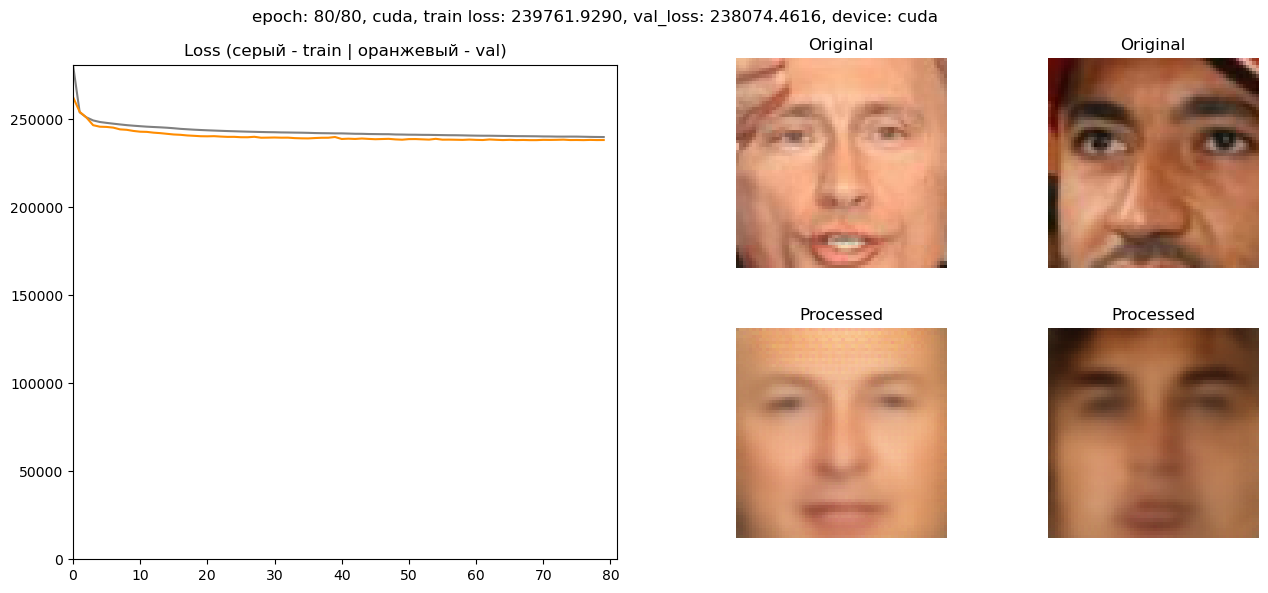

CPU times: total: 8min 20s
Wall time: 8min 18s


In [95]:
%%time
max_error = 0
device = DEVICE
model_faces = model_faces.cpu()
torch.cuda.empty_cache()

model_faces = model_faces.to(device)
visloader_enumerator = iter(vis_loader)

for e in tqdm( range(1,n_epochs+1) , desc='epoch',leave=False, position = 0):
    # ОБУЧЕНИЕ
    model_faces.train()
    train_losses_per_epoch = []
    i = 0
    n = len(train_dataset.data)
    for batch_data in tqdm(train_loader, desc='batch',leave=False, position = 1):
        batch = batch_data[0]
        optimizer.zero_grad()
        mu_train, logsigma_train, reconstruction_train = model_faces(batch.to(device))
        loss = criterion(batch.to(device).float(), mu_train, logsigma_train, reconstruction_train)
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())

    mean_train_loss = np.mean(train_losses_per_epoch)
    train_losses.append(mean_train_loss)
    if mean_train_loss > max_error:
        max_error = mean_train_loss

    # ВАЛИДАЦИЯ
    
    model_faces.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for batch_data_val in val_loader:
            batch_val = batch_data_val[0]
            mu_val, logsigma_val, reconstruction_val = model_faces(batch_val.to(device))
            loss = criterion(batch_val.to(device).float(), mu_val, logsigma_val, reconstruction_val)
            val_losses_per_epoch.append(loss.item())

    mean_val_loss = np.mean(val_losses_per_epoch)
    val_losses.append(mean_val_loss)
    if mean_val_loss > max_error:
        max_error = mean_val_loss

    # Визуализация
    model_faces.eval()  # testing mode
    images_vis = next(visloader_enumerator)
    x_images_vis = images_vis[0].to(DEVICE)
    
    mu_vis, logsigma_vis, reconstruction_vis = model_faces(x_images_vis.to(device))
    y_images_vis = reconstruction_vis.detach().cpu()
    x_images_vis = x_images_vis.cpu()
    clear_output(wait=True)
    
    ##################################################################
    # Отприсовка графиков ошибок и примеров обработанных изображений #
    ##################################################################

    # Определение размера фигуры
    fig = plt.figure(figsize=(12, 6))

    # Создание графика функции с заданным соотношением размеров
    ax1 = fig.add_subplot(121)
    ax1.plot(train_losses, label="Train loss"     ,color='gray')
    ax1.plot(val_losses,   label="Validation loss",color='darkorange')
    ax1.set_xlim(0,n_epochs+1)
    ax1.set_ylim(0,max_error)
    ax1.set_title("Loss (серый - train | оранжевый - val)")

    # Определение позиций для изображений
    # Прямоугольник: [x, y, width, height]
    base_width, base_height = 0.35, 0.35  # Увеличены на 25%

    image_positions = [(0.53, 0.55, base_width, base_height),  # Вычитаем (0.25 * height)/2 из y для компенсации
                       (0.79, 0.55, base_width, base_height),  # Высота изображений корректирована также
                       (0.53, 0.1, base_width, base_height),
                       (0.79, 0.1, base_width, base_height)]

    # Итерация для создания изображений
    for idx, pos in enumerate(image_positions):
        ax = fig.add_axes(pos)

        if idx == 0:
            ax.imshow(np.rollaxis(x_images_vis[0].numpy(), 0, 3))  
            ax.set_title(f"Original")
        if idx == 1:
            ax.imshow(np.rollaxis(x_images_vis[1].numpy(), 0, 3))  
            ax.set_title(f"Original")
        if idx == 2:
            ax.imshow(np.rollaxis(y_images_vis[0].numpy(), 0, 3))  
            ax.set_title(f"Processed")
        if idx == 3:
            ax.imshow(np.rollaxis(y_images_vis[1].numpy(), 0, 3))  
            ax.set_title(f"Processed")

        # Удаление осей для изображения
        ax.axis('off')

    plt.suptitle(f"epoch: {e}/{n_epochs}, {device}, train loss: {mean_train_loss:.4f}, val_loss: {mean_val_loss:.4f}, device: {DEVICE}")

    plt.tight_layout()
    plt.show()
        
model_faces = model_faces.cpu()
torch.cuda.empty_cache()        

In [97]:
# Получение латентных представлений для датасета
def get_latent_representations(vae_model, images_object: Union[np.ndarray, torch.Tensor,torch.utils.data.dataloader.DataLoader]) -> torch.Tensor:
    """
        Returns latent representation of images in loader object or of one given image 
        
        Parameters:
            vae_model - pytorch model
            images_object -    torch.utils.data.dataloader.DataLoader object
                            or numpy.ndarray
                            or torch.Tensor
    """
    vae_model.eval()
    latent_representations = []
    labels_arr = []
    i = 0
    
    if type(images_object) == torch.utils.data.dataloader.DataLoader:
        #print(type(loader))        
        with torch.no_grad():   # tqdm(train_loader, desc='batch',leave=False, position = 1):
            for data in tqdm(images_object, desc='batch',leave=False, position = 0):
                #print(i)
                #print(len(data))
                if len(data) == 1:
                    inputs = data[0]
                else:
                    inputs, labels = data

                #print(type(inputs[0]))
                #print(type(inputs[1]))

                #print(inputs.shape)
                mu, logvar = vae_model.encode(inputs.to(get_model_device(vae_model)))            
                z = vae_model.gaussian_sampler(mu, logvar)
                latent_representations.append(z)

                if len(data) == 2:
                    labels_arr.append(labels)
                i+=1
        if len(data) == 2:
            labels_list = [int(item.detach().cpu().numpy()) for sublist in labels_arr for item in sublist]#.detach().cpu().numpy()
            return torch.cat(latent_representations,dim=0).detach().cpu().numpy()          ,labels_list
        else:
            return torch.cat(latent_representations,dim=0).detach().cpu().numpy()
    elif type(images_object) == np.ndarray:
        if len(images_object.shape) != 4:
            images_object = images_object[np.newaxis,:]
        images_object = torch.FloatTensor(images_object)
        
        mu, logvar = vae_model.encode(images_object.to(get_model_device(vae_model)))            
        z = vae_model.gaussian_sampler(mu, logvar)
        #latent_representations.append(z)
        return z
        
    elif type(images_object) == torch.Tensor:
        if len(images_object.shape) != 4:
            images_object = images_object.unsqueeze(0)
        
        mu, logvar = vae_model.encode(images_object.to(get_model_device(vae_model)))            
        z = vae_model.gaussian_sampler(mu, logvar)
        #latent_representations.append(z)
        return z    
    

In [98]:
# <поучите латентные представления картинок из трейна>
codes = get_latent_representations(model_faces,train_loader)

batch:   0%|          | 0/329 [00:00<?, ?it/s]

In [99]:
# обучаем LSHForest
#from sklearn.neighbors import LSHForest
from sklearn.neighbors import NearestNeighbors


In [100]:
neighbors_obj = NearestNeighbors(n_neighbors=50, algorithm='ball_tree').fit(codes)

In [102]:
def get_similar( model         : VAE
                ,image         : Union[np.ndarray, torch.Tensor]
                ,images_array  : Union[np.ndarray, torch.Tensor]
                ,neighbors_obj : NearestNeighbors
                ,n_neighbors   : int = 5   ):
    # функция, которая берет тестовый image и с помощью метода kneighbours у LSHForest ищет ближайшие векторы
    # прогоняет векторы через декодер и получает картинки ближайших людей
    
    code = get_latent_representations(model, image).detach().cpu().numpy()
    distances, indices = neighbors_obj.kneighbors(code,n_neighbors=n_neighbors)
    return distances, images_array[indices]

In [103]:
def show_similar(model         : VAE, 
                 image         : Union[np.ndarray, torch.Tensor], 
                 images_array  : Union[np.ndarray, torch.Tensor],
                 neighbors_obj : NearestNeighbors, 
                 n_neighbors   : int = 5):

   # функция, которая принимает тестовый image, ищет ближайшие к нему и визуализирует результат

    distances,neighbors = get_similar( model,  image, images_array, neighbors_obj, n_neighbors=11)
    
    distances = np.squeeze(distances)

    plt.figure(figsize=[8,6])
    plt.subplot(3,4,1)
    plt.imshow(image.cpu().numpy().transpose([1,2,0]))
    plt.title("Original image")

    for i in range(11):
        plt.subplot(3,4,i+2)
        plt.imshow(neighbors[i].cpu().numpy().transpose([1,2,0]))
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

In [104]:
#<тут выведите самые похожие лица к какому-нибудь лицу из тестовой части датасета>

random_image = imgs_val[   int(random.uniform(0,len(imgs_val))), :]

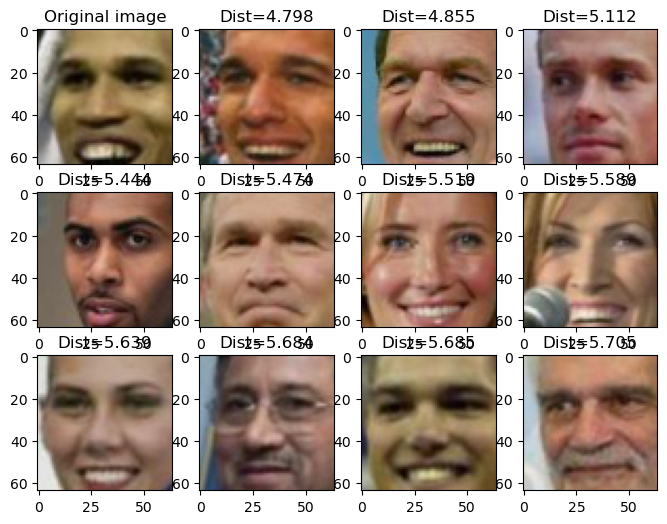

In [105]:
show_similar(model_faces, random_image, imgs_train, neighbors_obj, 5)

Спасибо за внимание :)
@varivodasergei

In [106]:
tprint('FINISHED')

FINISHED
